# Step 1: Data Preprocessing & Filtering

### First, we needed the dataset to be filtered for plays where the ball landed at least once in the outfield, which constituted a hit, and where a runner "attempted" to advance an extra base. This could be 1B -> 3B, 2B -> Home, 1B -> Home. But, also this meant the batter attempting for 2B or 3B. 

In [5]:
import pandas as pd
import pyarrow.dataset as pads
import os
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np
pd.set_option('display.max_columns', None)

In [6]:
data_path = "/Users/jackkalsched/Desktop/Independent_Projects/SMT-Data-Challenge-2025-Updated"

In [7]:
def readDataSubset(table_type, data_path):
    """
    Loads a specified SMT data subset as a PyArrow dataset.
    """
    valid_tables = ['ball_pos', 'game_events', 'game_info', 'player_pos', 'rosters']
    if table_type not in valid_tables:
        print("Invalid data subset name. Please try again with a valid data subset.")
        return None

    if table_type == 'rosters':
        return pads.dataset(source=os.path.join(data_path, 'rosters.csv'), format='csv')
    else:
        
        return pads.dataset(
            source=os.path.join(data_path, table_type),
            format='csv'
        )

### Reading in the datasets...

In [8]:
game_info_ds = readDataSubset('game_info', data_path)
game_events_ds = readDataSubset('game_events', data_path)
ball_pos_ds = readDataSubset('ball_pos', data_path)
player_pos_ds = readDataSubset('player_pos', data_path)
rosters_ds = readDataSubset('rosters', data_path)

In [9]:
import pyarrow as pa

### Keys that will be useful when adding descriptive columns to our dataset.
position_key = pd.DataFrame({
    "code": [*range(1, 14), 255, 14, 15, 16, 17, 18, 19],
    "position": [
        "pitcher", "catcher", "first baseman", "second baseman", "third baseman",
        "shortstop", "left field", "center field", "right field", "batter",
        "runner on first base", "runner on second base", "runner on third base",
        "ball event with no player (e.g., ball bounce)", "home plate umpire",
        "field umpire", "field umpire", "field umpire",
        "first base coach", "third base coach"
    ]
})

event_key = pd.DataFrame({
    "code": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 16],
    "play_type": [
        "pitch", "ball acquired", "throw (ball-in-play)", "ball hit into play", 
        "end of play", "pickoff throw", "ball acquired - unknown field position", 
        "throw (ball-in-play) - unknown field position", "ball deflection", 
        "ball deflection off of wall", "home run", "ball bounce"
    ]
})

In [10]:
game_info_df = game_info_ds.to_table().to_pandas()
game_events_df = game_events_ds.to_table().to_pandas()

In [11]:
### Data cleaning, merge game_info and game_events.
big_ie = pd.merge(
    game_events_df, 
    game_info_df, 
    on=['game_str', 'play_per_game'], 
    suffixes=('', '_dup')
)

big_ie = big_ie.loc[:, ~big_ie.columns.str.endswith('_dup')]

### Using the keys from the cell two prior, we join the key dictionary on this larger dataset to 
### then more easily see the player's position and what type of play the current row is.
big_ie['player_position'] = pd.to_numeric(big_ie['player_position'], errors='coerce').astype('Int64')
big_ie['event_code'] = pd.to_numeric(big_ie['event_code'], errors='coerce').astype('Int64')

big_ie = big_ie.merge(position_key, how='left', left_on='player_position', right_on='code').drop('code', axis=1)

big_ie = big_ie.merge(event_key, how='left', left_on='event_code', right_on='code').drop('code', axis=1)

### A quick fix we need to make is to the at-bat column. This will be crucial to our future model to have correctly tracked outs.

In [12]:
# ----- Enumerating the at-bat column ------ #
at_bat = list()
game_info_df_sub = big_ie[big_ie['at_bat'].notna()]
for row in range(len(game_info_df_sub)):
    if row==0:
        at_bat = at_bat + [1]
    elif game_info_df_sub.loc[row, 'game_str'] != game_info_df_sub.loc[row-1, 'game_str']:
        at_bat = at_bat + [1]
    elif game_info_df_sub.loc[row, 'batter'] == game_info_df_sub.loc[row-1, 'batter']:
        at_bat = at_bat + [at_bat[row-1]]
    else:
        at_bat = at_bat + [at_bat[row-1] + 1]

In [13]:
# ----- Reassigning at-bat column to new dataframe ----- #
game_info_df_sub['at_bat'] = at_bat
final_ie = game_info_df_sub
final_ie.head()

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,position,play_type
0,y1_d069_ACN_QEA,1,1,1,14853,1,1,QEA,ACN,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NA,NA,NA,pitcher,pitch
1,y1_d069_ACN_QEA,1,1,1,15303,2,2,QEA,ACN,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NA,NA,NA,catcher,ball acquired
2,y1_d069_ACN_QEA,1,1,1,15303,0,5,QEA,ACN,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NA,NA,NA,NaN,end of play
3,y1_d069_ACN_QEA,2,1,2,27753,1,1,QEA,ACN,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NA,NA,NA,pitcher,pitch
4,y1_d069_ACN_QEA,2,1,2,28253,2,2,QEA,ACN,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NA,NA,NA,catcher,ball acquired


In [14]:
# ----- Function to mark outs using sequential event patterns ----- #
def mark_outs_by_event_pattern(df):
    """
    Adds an 'is_out' column based on 2 rules:

    Rule 1: Within a batter’s PA:
      - At least one 'ball hit into play'
      - Batter does NOT end up on base in the first row after the PA

    Rule 2: Within a batter’s PA:
      - At least three 'pitch' entries in play_type
      - Batter does NOT end up on base in the first row after the PA

    We mark the LAST row of each PA when an out is detected by either rule.
    """
    # Create a new copy of the dataframe for error prevention
    df = df.copy()
    df.sort_values(['game_str', 'top_bottom_inning', 'at_bat', 'play_id'], inplace=True)

    df['next_first_base']  = df['first_baserunner'].shift(-1)
    df['next_second_base'] = df['second_baserunner'].shift(-1)
    df['next_third_base']  = df['third_baserunner'].shift(-1)

    # placeholders for the two rules
    is_out_r1 = pd.Series(False, index=df.index)
    is_out_r2 = pd.Series(False, index=df.index)

    # helper function to test if the batter is on any base in the next row
    def batter_on_base(next_row, batter):
        return any(
            batter == next_row.get(col)
            for col in ['first_baserunner', 'second_baserunner', 'third_baserunner']
        )

    # iterate each PA
    for (_, _, _), group in df.groupby(['game_str', 'top_bottom_inning', 'at_bat']):
        if group.empty:
            continue

        seq = list(group['play_type'])
        
        # skip any PA in which a home run occurs
        if "home run" in seq:
            continue

        idxs = list(group.index)
        last_i = idxs[-1]
        batter = group['batter'].iloc[0]
        loc = df.index.get_loc(last_i)

        # look ahead one row if it exists
        if loc + 1 < len(df):
            next_row = df.iloc[loc + 1]
        else:
            next_row = {}

        # RULE 1: any "ball hit into play" + batter not on base next row
        if "ball hit into play" in seq and not batter_on_base(next_row, batter):
            is_out_r1.at[last_i] = True

        # RULE 2: at least three "pitch" entries + batter not on base next row
        if seq.count("pitch") >= 3 and not batter_on_base(next_row, batter):
            is_out_r2.at[last_i] = True

    # combine rule flags
    df['is_out'] = (is_out_r1 | is_out_r2).fillna(False)

    # clean up helper columns
    return df.drop(columns=['next_first_base', 'next_second_base', 'next_third_base'])


# ----- Second function to calculate the current number of outs in the half-inning ----- #
def calculate_outs(df):
    """
    Add a cumulative 'outs' column that resets at each new half-inning,
    counting only when is_out is True.
    """
    
    #Create copied dataframe for error prevention 
    df = df.copy()
    df['outs'] = 0
    group_cols = ['game_str', 'top_bottom_inning']

    # Helper function to count outs
    def count_outs(subdf):
        outs = 0
        outs_list = []
        for is_out in subdf['is_out']:
            if bool(is_out):
                outs += 1
            outs_list.append(outs)
            if outs >= 3:
                outs = 0
        subdf['outs'] = outs_list
        return subdf

    return df.groupby(group_cols, group_keys=False).apply(count_outs)

#Assign a marked outs dataframe
marked = mark_outs_by_event_pattern(final_ie)

#Calculate outs in marked dataframe
with_outs = calculate_outs(marked).sort_values(['game_str', 'play_id'])
with_outs

/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_4462/2585186763.py:97: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols, group_keys=False).apply(count_outs)


,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,position,play_type,is_out,outs
7894,y1_d001_CGA_QEA,1,1,1,8699,1,1,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1458,NA,NA,NA,pitcher,pitch,False,0
7895,y1_d001_CGA_QEA,1,1,1,9199,2,2,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1458,NA,NA,NA,catcher,ball acquired,False,0
7896,y1_d001_CGA_QEA,1,1,1,9199,0,5,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1458,NA,NA,NA,NaN,end of play,False,0
7897,y1_d001_CGA_QEA,2,1,2,24149,1,1,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1458,NA,NA,NA,pitcher,pitch,False,0
7898,y1_d001_CGA_QEA,2,1,2,24599,10,4,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1458,NA,NA,NA,batter,ball hit into play,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161260,y2_d099_YJD_RZQ,291,78,291,1537052091220,2,2,RZQ,YJD,top,RZQ-0368,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0007,NA,NA,NA,catcher,ball acquired,False,1
161261,y2_d099_YJD_RZQ,291,78,291,1537052091220,0,5,RZQ,YJD,top,RZQ-0368,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0007,NA,NA,NA,NaN,end of play,False,1
161262,y2_d099_YJD_RZQ,292,78,292,47698,0,5,RZQ,YJD,top,RZQ-0368,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0007,NA,NA,NA,NaN,end of play,False,1
161263,y2_d099_YJD_RZQ,292,78,292,1537052107870,1,1,RZQ,YJD,top,RZQ-0368,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0007,NA,NA,NA,pitcher,pitch,False,1


### There was double and triple checking that we did in a separate notebook to confirm the pattern and number of outs overall. We felt confident enough in this particular formula and methodology to proceed. 

### Here, we'll filter for "non-plays" and exclude them from the larger dataset. "Non-plays" are plays we don't need for our analysis, any play that isn't a hit to the outfield with an extra base opportunity in play.

In [15]:
prev2 = with_outs['event_code'].shift(2)
prev1 = with_outs['event_code'].shift(1)
curr  = with_outs['event_code']
next1 = with_outs['event_code'].shift(-1)
next2 = with_outs['event_code'].shift(-2)

# ----- Defining patterns that are "non-plays", like a non-hit pitch, a foul ball, etc. -------- #
pattern1 = (curr == 5) & (prev1 == 2) & (prev2 == 1)  # non hit pitch
pattern2 = (curr == 1) & (next1 == 2) & (next2 == 5)   
pattern3 = (curr == 2) & (prev1 == 1) & (next1 == 5) 
pattern4 = (curr == 5) & (prev1 == 4) # foul 
pattern5 = (curr == 4) & (next1 == 5) 
pattern6 = (curr == 1) # don't care about pitches

# ------ Filtering for non non-plays... sooooo plays. ------- #
with_outs['non_play'] = pattern1 | pattern2 | pattern3 | pattern4 | pattern5 | pattern6

balls_in_play = with_outs[with_outs['non_play'] == False]
balls_in_play.head()

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,position,play_type,is_out,outs,non_play
7898,y1_d001_CGA_QEA,2,1,2,24599,10,4,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1458,NA,NA,NA,batter,ball hit into play,False,0,False
7899,y1_d001_CGA_QEA,2,1,2,24699,255,16,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1458,NA,NA,NA,"ball event with no player (e.g., ball bounce)",ball bounce,False,0,False
7900,y1_d001_CGA_QEA,2,1,2,25299,255,16,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1458,NA,NA,NA,"ball event with no player (e.g., ball bounce)",ball bounce,False,0,False
7901,y1_d001_CGA_QEA,2,1,2,25649,255,16,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1458,NA,NA,NA,"ball event with no player (e.g., ball bounce)",ball bounce,False,0,False
7902,y1_d001_CGA_QEA,2,1,2,25999,255,16,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1458,NA,NA,NA,"ball event with no player (e.g., ball bounce)",ball bounce,False,0,False


In [16]:
ball_pos_df = ball_pos_ds.to_table().to_pandas()
player_pos_df = player_pos_ds.to_table().to_pandas()

### Rather than having the dataset be abnormally long, we'll pivot the dataset so it's wider. 

In [17]:
player_pos_pivot = player_pos_df.pivot_table(
    index=['game_str', 'play_id', 'timestamp'],
    columns='player_position',
    values=['field_x', 'field_y']
)

player_pos_pivot

field_x                                     \
player_position                        1       2        3        4        5    
game_str        play_id timestamp                                              
y1_d001_CGA_QEA 1       8699       0.1728  0.0555  69.6597  48.7089 -43.3815   
                        8749       0.1926  0.0270  69.5571  48.6915 -43.3473   
                        8799       0.2136 -0.0012  69.4509  48.6777 -43.3158   
                        8849       0.2355 -0.0297  69.3420  48.6672 -43.2861   
                        8899       0.2580 -0.0582  69.2310  48.6591 -43.2585   
...                                   ...     ...      ...      ...      ...   
y2_d099_YJD_RZQ 292     10147948   1.0521  0.0000  71.2845  52.4973 -48.1095   
                        10147998   1.1016  0.0000  71.2005  52.5603 -48.1713   
                        10148048   1.1517  0.0000  71.1162  52.6233 -48.2328   
                        10148098   1.2018  0.0000  71.0316  52.6863 -48.2943   
                        10148148   1.2522  0.0000  70.9473  52.7490 -48.3558   

                                                                         \
player_position                         6         7        8         9    
game_str        play_id timestamp                                         
y1_d001_CGA_QEA 1       8699      -32.7906 -138.6321 -31.1307  109.1400   
                        8749      -32.7612 -138.5343 -31.1985  109.1367   
                        8799      -32.7306 -138.4380 -31.2663  109.1358   
                        8849      -32.6991 -138.3426 -31.3341  109.1370   
                        8899      -32.6676 -138.2490 -31.4019  109.1400   
...                                    ...       ...      ...       ...   
y2_d099_YJD_RZQ 292     10147948  -12.5124 -111.0312 -15.5784  118.3521   
                        10147998  -12.5040 -111.0039 -15.6582  118.3509   
                        10148048  -12.4956 -110.9769 -15.7377  118.3494   
                        10148098  -12.4869 -110.9499 -15.8169  118.3482   
                        10148148  -12.4782 -110.9232 -15.8964  118.3470   

                                                                             \
player_position                        10  11  12  13   14  15  16       17   
game_str        play_id timestamp                                             
y1_d001_CGA_QEA 1       8699       3.2805 NaN NaN NaN  NaN NaN NaN -84.9531   
                        8749       3.2715 NaN NaN NaN  NaN NaN NaN -84.9054   
                        8799       3.2625 NaN NaN NaN  NaN NaN NaN -84.8586   
                        8849       3.2535 NaN NaN NaN  NaN NaN NaN -84.8124   
                        8899       3.2445 NaN NaN NaN  NaN NaN NaN -84.7671   
...                                   ...  ..  ..  ..  ...  ..  ..      ...   
y2_d099_YJD_RZQ 292     10147948   2.9841 NaN NaN NaN  0.0 NaN NaN      NaN   
                        10147998   3.0297 NaN NaN NaN  0.0 NaN NaN      NaN   
                        10148048   3.0753 NaN NaN NaN  0.0 NaN NaN      NaN   
                        10148098   3.1206 NaN NaN NaN  0.0 NaN NaN      NaN   
                        10148148   3.1662 NaN NaN NaN  0.0 NaN NaN      NaN   

                                                     field_y                   \
player_position                         18       19       1       2        3    
game_str        play_id timestamp                                               
y1_d001_CGA_QEA 1       8699       87.1338 -77.6565  56.1612 -5.9649  87.1266   
                        8749       87.0300 -77.6559  55.9401 -5.9316  87.0279   
                        8799       86.9466 -77.6556  55.7199 -5.8986  86.9268   
                        8849       86.8710 -77.6550  55.5003 -5.8653  86.8236   
                        8899       86.8119 -77.6547  55.2816 -5.8323  86.7192   
...                                    ...      ...      ...     ...      ...   
y2_d099_YJD_RZQ 292     10

In [18]:
# ---- Organize columns by renaming ------ #
player_pos_pivot.columns = [f"{coord}_{pos}" for coord, pos in player_pos_pivot.columns]
player_pos_pivot = player_pos_pivot.reset_index()
player_pos_pivot

,game_str,play_id,timestamp,field_x_1,field_x_2,field_x_3,field_x_4,field_x_5,field_x_6,field_x_7,field_x_8,field_x_9,field_x_10,field_x_11,field_x_12,field_x_13,field_x_14,field_x_15,field_x_16,field_x_17,field_x_18,field_x_19,field_y_1,field_y_2,field_y_3,field_y_4,field_y_5,field_y_6,field_y_7,field_y_8,field_y_9,field_y_10,field_y_11,field_y_12,field_y_13,field_y_14,field_y_15,field_y_16,field_y_17,field_y_18,field_y_19
0,y1_d001_CGA_QEA,1,8699,0.1728,0.0555,69.6597,48.7089,-43.3815,-32.7906,-138.6321,-31.1307,109.1400,3.2805,NaN,NaN,NaN,NaN,NaN,NaN,-84.9531,87.1338,-77.6565,56.1612,-5.9649,87.1266,132.0027,70.1199,144.9864,230.9421,307.0320,258.7404,1.0482,NaN,NaN,NaN,NaN,NaN,NaN,83.5506,86.5839,55.5597
1,y1_d001_CGA_QEA,1,8749,0.1926,0.0270,69.5571,48.6915,-43.3473,-32.7612,-138.5343,-31.1985,109.1367,3.2715,NaN,NaN,NaN,NaN,NaN,NaN,-84.9054,87.0300,-77.6559,55.9401,-5.9316,87.0279,131.9445,70.0149,144.7236,230.9007,306.8640,258.6951,1.0749,NaN,NaN,NaN,NaN,NaN,NaN,83.4954,86.4639,55.5600
2,y1_d001_CGA_QEA,1,8799,0.2136,-0.0012,69.4509,48.6777,-43.3158,-32.7306,-138.4380,-31.2663,109.1358,3.2625,NaN,NaN,NaN,NaN,NaN,NaN,-84.8586,86.9466,-77.6556,55.7199,-5.8986,86.9268,131.8860,69.9072,144.4596,230.8596,306.6960,258.6498,1.1013,NaN,NaN,NaN,NaN,NaN,NaN,83.4417,86.3532,55.5600
3,y1_d001_CGA_QEA,1,8849,0.2355,-0.0297,69.3420,48.6672,-43.2861,-32.6991,-138.3426,-31.3341,109.1370,3.2535,NaN,NaN,NaN,NaN,NaN,NaN,-84.8124,86.8710,-77.6550,55.5003,-5.8653,86.8236,131.8281,69.7974,144.1950,230.8182,306.5250,258.6045,1.1280,NaN,NaN,NaN,NaN,NaN,NaN,83.3889,86.2644,55.5603
4,y1_d001_CGA_QEA,1,8899,0.2580,-0.0582,69.2310,48.6591,-43.2585,-32.6676,-138.2490,-31.4019,109.1400,3.2445,NaN,NaN,NaN,NaN,NaN,NaN,-84.7671,86.8119,-77.6547,55.2816,-5.8323,86.7192,131.7699,69.6861,143.9307,230.7768,306.3570,258.5595,1.1544,NaN,NaN,NaN,NaN,NaN,NaN,83.3376,86.1855,55.5600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6058959,y2_d099_YJD_RZQ,292,10147948,1.0521,0.0000,71.2845,52.4973,-48.1095,-12.5124,-111.0312,-15.5784,118.3521,2.9841,NaN,NaN,NaN,0.0,NaN,NaN,NaN,89.5809,-82.3752,55.5234,-4.5000,94.5525,140.0055,110.9124,153.1509,268.1436,308.7033,257.0847,-0.4713,NaN,NaN,NaN,-6.6,NaN,NaN,NaN,76.5105,80.6157
6058960,y2_d099_YJD_RZQ,292,10147998,1.1016,0.0000,71.2005,52.5603,-48.1713,-12.5040,-111.0039,-15.6582,118.3509,3.0297,NaN,NaN,NaN,0.0,NaN,NaN,NaN,89.6301,-82.4028,55.4679,-4.5000,94.5054,139.9809,110.8392,153.1242,268.1094,308.6394,257.0739,-0.4560,NaN,NaN,NaN,-6.6,NaN,NaN,NaN,76.5072,80.6184
6058961,y2_d099_YJD_RZQ,292,10148048,1.1517,0.0000,71.1162,52.6233,-48.2328,-12.4956,-110.9769,-15.7377,118.3494,3.0753,NaN,NaN,NaN,0.0,NaN,NaN,NaN,89.6787,-82.4304,55.4112,-4.5000,94.4586,139.9563,110.7657,153.0978,268.0752,308.5755,257.0628,-0.4404,NaN,NaN,NaN,-6.6,NaN,NaN,NaN,76.5042,80.6208
6058962,y2_d099_YJD_RZQ,292,10148098,1.2018,0.0000,71.0316,52.6863,-48.2943,-12.4869,-110.9499,-15.8169,118.3482,3.1206,NaN,NaN,NaN,0.0,NaN,NaN,NaN,89.7270,-82.4580,55.3542,-4.5000,94.4121,139.9317,110.6922,153.0711,268.0416,308.5116,257.0520,-0.4248,NaN,NaN,NaN,-6.6,NaN,NaN,NaN,76.5012,80.6229


In [19]:
# ----- Candidate plays are plays where there is at least a runner on first or second ------ #
candidate_plays = balls_in_play[
    (balls_in_play['first_baserunner'] != 'NA') | (balls_in_play['second_baserunner'] != 'NA')
]

candidate_plays

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,position,play_type,is_out,outs,non_play
7913,y1_d001_CGA_QEA,4,2,4,84049,10,4,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,batter,ball hit into play,False,0,False
7914,y1_d001_CGA_QEA,4,2,4,86099,255,16,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,"ball event with no player (e.g., ball bounce)",ball bounce,False,0,False
7915,y1_d001_CGA_QEA,4,2,4,86799,7,2,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,left field,ball acquired,False,0,False
7916,y1_d001_CGA_QEA,4,2,4,88399,7,3,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,left field,throw (ball-in-play),False,0,False
7917,y1_d001_CGA_QEA,4,2,4,89699,6,2,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,shortstop,ball acquired,False,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161189,y2_d099_YJD_RZQ,271,72,271,1537051423320,255,16,RZQ,YJD,top,RZQ-0368,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0397,YJD-0132,NA,NA,"ball event with no player (e.g., ball bounce)",ball bounce,False,1,False
161190,y2_d099_YJD_RZQ,271,72,271,1537051425470,5,2,RZQ,YJD,top,RZQ-0368,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0397,YJD-0132,NA,NA,third baseman,ball acquired,False,1,False
161191,y2_d099_YJD_RZQ,271,72,271,1537051426270,5,3,RZQ,YJD,top,RZQ-0368,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0397,YJD-0132,NA,NA,third baseman,throw (ball-in-play),False,1,False
161192,y2_d099_YJD_RZQ,271,72,271,1537051427120,3,2,RZQ,YJD,top,RZQ-0368,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0397,YJD-0132,NA,NA,first baseman,ball acquired,False,1,False


In [20]:
# ----- Merging both above datasets ----- #
cp_pos = candidate_plays.merge(
    player_pos_pivot,
    on=['game_str', 'play_id', 'timestamp'],
    how='left'
).sort_values(by=['game_str', 'timestamp', 'play_id'])

cp_pos


,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,position,play_type,is_out,outs,non_play,field_x_1,field_x_2,field_x_3,field_x_4,field_x_5,field_x_6,field_x_7,field_x_8,field_x_9,field_x_10,field_x_11,field_x_12,field_x_13,field_x_14,field_x_15,field_x_16,field_x_17,field_x_18,field_x_19,field_y_1,field_y_2,field_y_3,field_y_4,field_y_5,field_y_6,field_y_7,field_y_8,field_y_9,field_y_10,field_y_11,field_y_12,field_y_13,field_y_14,field_y_15,field_y_16,field_y_17,field_y_18,field_y_19
0,y1_d001_CGA_QEA,4,2,4,84049,10,4,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,batter,ball hit into play,False,0,False,0.8787,-1.8429,56.7573,25.7118,-44.5200,-25.2048,-133.4985,-32.6625,95.8002,2.4033,49.7067,NaN,NaN,NaN,72.3738,8.6856,NaN,NaN,-81.6675,54.2682,-4.4274,64.0506,122.0712,70.7724,131.5413,230.9931,288.4542,262.5258,-0.0645,78.2334,NaN,NaN,NaN,70.4334,103.8762,NaN,NaN,65.9304
1,y1_d001_CGA_QEA,4,2,4,86099,255,16,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,"ball event with no player (e.g., ball bounce)",ball bounce,False,0,False,0.8067,-0.4992,54.9321,17.0340,-47.4159,-40.9239,-126.5103,-32.5383,94.5087,20.6970,29.0952,NaN,NaN,NaN,71.6985,8.0838,NaN,NaN,-79.1304,49.8015,-4.2675,65.1348,124.4832,67.9965,125.2710,215.0952,285.0882,260.6424,12.4002,99.8850,NaN,NaN,NaN,67.0239,103.7217,NaN,NaN,64.1400
2,y1_d001_CGA_QEA,4,2,4,86799,7,2,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,left field,ball acquired,False,0,False,-3.2481,-0.4107,54.2241,14.1813,-50.2191,-50.6505,-123.7800,-32.4504,94.2384,33.8289,19.0095,NaN,NaN,NaN,70.6788,7.6758,NaN,NaN,-78.9333,44.5842,-1.7121,64.6944,125.2791,66.3126,123.8514,206.6874,282.5754,259.1673,20.8035,109.6140,NaN,NaN,NaN,63.4512,104.1897,NaN,NaN,63.4470
3,y1_d001_CGA_QEA,4,2,4,88399,7,3,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,left field,throw (ball-in-play),False,0,False,-12.5880,-1.0491,52.9533,8.4936,-55.7001,-70.6860,-119.7978,-30.3444,94.3872,56.6424,-0.4104,NaN,NaN,NaN,69.2358,5.9955,NaN,NaN,-79.7931,36.9105,3.2631,63.8367,126.6075,64.5138,121.1397,196.4517,277.6065,255.4932,48.1422,125.7387,NaN,NaN,NaN,57.6384,104.7717,NaN,NaN,63.4905
4,y1_d001_CGA_QEA,4,2,4,89699,6,2,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,shortstop,ball acquired,False,0,False,-17.7561,-1.4526,54.0573,4.6386,-58.6998,-80.6802,-120.1602,-27.5835,95.9751,60.4419,-4.0221,NaN,NaN,NaN,69.1008,2.5425,NaN,NaN,-79.6893,37.0581,6.8436,63.0855,126.7554,64.5243,121.6113,197.3796,274.5747,252.3060,70.8816,126.3249,NaN,NaN,NaN,55.8636,104.7033,NaN,NaN,63.6120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41865,y2_d099_YJD_RZQ,271,72,271,1537051423320,255,16,RZQ,YJD,top,RZQ-0368,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0397,YJD-0132,NA,NA,"ball event with no player (e.g., ball bounce)",ball bounce,False,1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41866,y2_d099_YJD_RZQ,271,72,271,1537051425470,5,2,RZQ,YJD,top,RZQ-0368,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0397,YJD-0132,NA,NA,third baseman,ball acquired,False,1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [21]:
# ----- Adding in ball position data in the same, pivoted, format ------ #
ball_pos_pivot = ball_pos_df.pivot_table(
    index=['game_str', 'play_id', 'timestamp'],
    values=['ball_position_x', 'ball_position_y', 'ball_position_z']
).reset_index()

ball_pos_pivot

,game_str,play_id,timestamp,ball_position_x,ball_position_y,ball_position_z
0,y1_d001_CGA_QEA,1,8699,-1.907532,55.804200,5.702790
1,y1_d001_CGA_QEA,1,8749,-1.651071,49.260600,5.484120
2,y1_d001_CGA_QEA,1,8799,-1.412958,42.791100,5.213850
3,y1_d001_CGA_QEA,1,8849,-1.193196,36.396300,4.891980
4,y1_d001_CGA_QEA,1,8899,-0.991785,30.075600,4.518540
...,...,...,...,...,...,...
2303279,y2_d099_YJD_RZQ,292,10147948,0.576795,18.719670,3.902880
2303280,y2_d099_YJD_RZQ,292,10147998,0.719802,12.818610,3.298110
2303281,y2_d099_YJD_RZQ,292,10148048,0.870270,6.958620,2.618214
2303282,y2_d099_YJD_RZQ,292,10148098,1.028199,1.139652,1.863210


In [22]:
# ------ Adding ball_pos data onto larger candidate plays dataset ------- #
full_plays = cp_pos.merge(
    ball_pos_pivot,
    on=['game_str', 'play_id', 'timestamp'],
    how='left'
)

full_plays

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,position,play_type,is_out,outs,non_play,field_x_1,field_x_2,field_x_3,field_x_4,field_x_5,field_x_6,field_x_7,field_x_8,field_x_9,field_x_10,field_x_11,field_x_12,field_x_13,field_x_14,field_x_15,field_x_16,field_x_17,field_x_18,field_x_19,field_y_1,field_y_2,field_y_3,field_y_4,field_y_5,field_y_6,field_y_7,field_y_8,field_y_9,field_y_10,field_y_11,field_y_12,field_y_13,field_y_14,field_y_15,field_y_16,field_y_17,field_y_18,field_y_19,ball_position_x,ball_position_y,ball_position_z
0,y1_d001_CGA_QEA,4,2,4,84049,10,4,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,batter,ball hit into play,False,0,False,0.8787,-1.8429,56.7573,25.7118,-44.5200,-25.2048,-133.4985,-32.6625,95.8002,2.4033,49.7067,NaN,NaN,NaN,72.3738,8.6856,NaN,NaN,-81.6675,54.2682,-4.4274,64.0506,122.0712,70.7724,131.5413,230.9931,288.4542,262.5258,-0.0645,78.2334,NaN,NaN,NaN,70.4334,103.8762,NaN,NaN,65.9304,-0.080938,-1.274727,2.062173
1,y1_d001_CGA_QEA,4,2,4,86099,255,16,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,"ball event with no player (e.g., ball bounce)",ball bounce,False,0,False,0.8067,-0.4992,54.9321,17.0340,-47.4159,-40.9239,-126.5103,-32.5383,94.5087,20.6970,29.0952,NaN,NaN,NaN,71.6985,8.0838,NaN,NaN,-79.1304,49.8015,-4.2675,65.1348,124.4832,67.9965,125.2710,215.0952,285.0882,260.6424,12.4002,99.8850,NaN,NaN,NaN,67.0239,103.7217,NaN,NaN,64.1400,-100.946400,177.866100,-0.328377
2,y1_d001_CGA_QEA,4,2,4,86799,7,2,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,left field,ball acquired,False,0,False,-3.2481,-0.4107,54.2241,14.1813,-50.2191,-50.6505,-123.7800,-32.4504,94.2384,33.8289,19.0095,NaN,NaN,NaN,70.6788,7.6758,NaN,NaN,-78.9333,44.5842,-1.7121,64.6944,125.2791,66.3126,123.8514,206.6874,282.5754,259.1673,20.8035,109.6140,NaN,NaN,NaN,63.4512,104.1897,NaN,NaN,63.4470,-123.916800,206.003400,-0.396300
3,y1_d001_CGA_QEA,4,2,4,88399,7,3,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,left field,throw (ball-in-play),False,0,False,-12.5880,-1.0491,52.9533,8.4936,-55.7001,-70.6860,-119.7978,-30.3444,94.3872,56.6424,-0.4104,NaN,NaN,NaN,69.2358,5.9955,NaN,NaN,-79.7931,36.9105,3.2631,63.8367,126.6075,64.5138,121.1397,196.4517,277.6065,255.4932,48.1422,125.7387,NaN,NaN,NaN,57.6384,104.7717,NaN,NaN,63.4905,-116.801400,196.812600,5.071500
4,y1_d001_CGA_QEA,4,2,4,89699,6,2,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,shortstop,ball acquired,False,0,False,-17.7561,-1.4526,54.0573,4.6386,-58.6998,-80.6802,-120.1602,-27.5835,95.9751,60.4419,-4.0221,NaN,NaN,NaN,69.1008,2.5425,NaN,NaN,-79.6893,37.0581,6.8436,63.0855,126.7554,64.5243,121.6113,197.3796,274.5747,252.3060,70.8816,126.3249,NaN,NaN,NaN,55.8636,104.7033,NaN,NaN,63.6120,-82.183500,123.786300,2.159709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41865,y2_d099_YJD_RZQ,271,72,271,1537051423320,255,16,RZQ,YJD,top,RZQ-0368,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0397,YJD-0132,NA,NA,"ball event with no player (e.g., ball bounce)",ball bounce,False,1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41866,y2_d099_YJD_RZQ,271,7

### In order to detect attempts, we created an arbitrary boundary about half way down a baseline. If the runner passes this boundary or coordinate threshold, we deduce that they are attempting to advance to that base.

In [23]:
def detect_attempts(df):

    # ----- ~half way down the third baseline for runners attempting to score ----- #
    home_x_thresh = -35
    home_y_thresh = 35

    # ----- ~half way down the second to third baseline for runners attempting to reach third ----- #
    third_x_thresh = -35
    third_y_thresh = 90
    
    # ----- ~half way down the first to second baseline for hitters attempting to reach second ----- #
    second_x_thresh = 40
    second_y_thresh = 90

    attempts = []

    for (game_str, play_id), group in df.groupby(['game_str', 'play_id']):

        group_sorted = group.sort_values('timestamp')

        # ----- Detecting attempts for hitters to 2nd or 3rd ----- #
        f10_x = group_sorted['field_x_10']
        f10_y = group_sorted['field_y_10']
        f10_second_attempt = (f10_x < second_x_thresh) & (f10_y > second_y_thresh)
        f10_third_attempt = (f10_x < third_x_thresh) & (f10_y < third_y_thresh)

        # ----- Detecting attempts for runners on 1st for 3rd or Home ----- #
        f11_x = group_sorted['field_x_11']
        f11_y = group_sorted['field_y_11']
        f11_home_attempt = (f11_x > home_x_thresh) & (f11_y < home_y_thresh)
        f11_third_attempt = (f11_x < third_x_thresh) & (f11_y < third_y_thresh)

        # ----- Detecting attempts for runners on 2nd for Home ----- #
        f12_x = group_sorted['field_x_12']
        f12_y = group_sorted['field_y_12']
        f12_home_attempt = (f12_x > home_x_thresh) & (f12_y < home_y_thresh)
        
        # ----- Append all attempts ----- #

        if f11_home_attempt.any():
            attempts.append({
                'game_str': game_str,
                'play_id': play_id,
                'player_position': 11,
                'from_base': '1B',
                'to_base': 'Home',
                'attempted': True
            })

        if f11_third_attempt.any():
            attempts.append({
                'game_str': game_str,
                'play_id': play_id,
                'player_position': 11,
                'from_base': '1B',
                'to_base': '3B',
                'attempted': True
            })

        if f12_home_attempt.any():
            attempts.append({
                'game_str': game_str,
                'play_id': play_id,
                'player_position': 12,
                'from_base': '2B',
                'to_base': 'Home',
                'attempted': True
            })

        if f10_second_attempt.any():
            attempts.append({
                'game_str': game_str,
                'play_id': play_id,
                'player_position': 10,
                'from_base': 'Home',
                'to_base': '2B',
                'attempted': True
            })


        if f10_third_attempt.any():
            attempts.append({
                'game_str': game_str,
                'play_id': play_id,
                'player_position': 10,
                'from_base': 'Home',
                'to_base': '3B',
                'attempted': True
            })
            

    return pd.DataFrame(attempts)

In [24]:
# ---- Apply function to dataset ----- #
attempts_df = detect_attempts(full_plays)

attempts_df['attempt_label'] = ('runner_' + attempts_df['player_position'].astype(str) + '_attempt_' + attempts_df['to_base'])

# ---- Pivot the dataset to make it wide, again ----- #
attempts_wide = attempts_df.pivot_table(
    index=['game_str', 'play_id'],
    columns='attempt_label',
    values='attempted',
    aggfunc='first'
).reset_index()

attempts_wide = attempts_wide.fillna(False)

attempts_wide

/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_4462/3159439971.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  attempts_wide = attempts_wide.fillna(False)


attempt_label,game_str,play_id,runner_10_attempt_2B,runner_10_attempt_3B,runner_11_attempt_3B,runner_11_attempt_Home,runner_12_attempt_Home
0,y1_d001_CGA_QEA,17,False,False,False,False,True
1,y1_d001_CGA_QEA,108,True,True,True,True,True
2,y1_d001_CGA_QEA,114,True,False,False,False,False
3,y1_d001_CGA_QEA,216,True,False,False,False,True
4,y1_d002_CGA_QEA,92,True,False,True,False,True
...,...,...,...,...,...,...,...
954,y2_d097_YJD_RZQ,19,False,False,True,False,False
955,y2_d097_YJD_RZQ,53,True,False,True,True,False
956,y2_d097_YJD_RZQ,135,False,False,True,False,False
957,y2_d097_YJD_RZQ,158,True,False,True,True,False


In [25]:
# ----- Merge back onto larger dataset ----- #
full_plays_att = full_plays.merge(
    attempts_wide,
    on=['game_str', 'play_id'],
    how='left'
)


full_plays_att.head(10)

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,position,play_type,is_out,outs,non_play,field_x_1,field_x_2,field_x_3,field_x_4,field_x_5,field_x_6,field_x_7,field_x_8,field_x_9,field_x_10,field_x_11,field_x_12,field_x_13,field_x_14,field_x_15,field_x_16,field_x_17,field_x_18,field_x_19,field_y_1,field_y_2,field_y_3,field_y_4,field_y_5,field_y_6,field_y_7,field_y_8,field_y_9,field_y_10,field_y_11,field_y_12,field_y_13,field_y_14,field_y_15,field_y_16,field_y_17,field_y_18,field_y_19,ball_position_x,ball_position_y,ball_position_z,runner_10_attempt_2B,runner_10_attempt_3B,runner_11_attempt_3B,runner_11_attempt_Home,runner_12_attempt_Home
0,y1_d001_CGA_QEA,4,2,4,84049,10,4,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,batter,ball hit into play,False,0,False,0.8787,-1.8429,56.7573,25.7118,-44.5200,-25.2048,-133.4985,-32.6625,95.8002,2.4033,49.7067,NaN,NaN,NaN,72.3738,8.6856,NaN,NaN,-81.6675,54.2682,-4.4274,64.0506,122.0712,70.7724,131.5413,230.9931,288.4542,262.5258,-0.0645,78.2334,NaN,NaN,NaN,70.4334,103.8762,NaN,NaN,65.9304,-0.080938,-1.274727,2.062173,NaN,NaN,NaN,NaN,NaN
1,y1_d001_CGA_QEA,4,2,4,86099,255,16,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,"ball event with no player (e.g., ball bounce)",ball bounce,False,0,False,0.8067,-0.4992,54.9321,17.0340,-47.4159,-40.9239,-126.5103,-32.5383,94.5087,20.6970,29.0952,NaN,NaN,NaN,71.6985,8.0838,NaN,NaN,-79.1304,49.8015,-4.2675,65.1348,124.4832,67.9965,125.2710,215.0952,285.0882,260.6424,12.4002,99.8850,NaN,NaN,NaN,67.0239,103.7217,NaN,NaN,64.1400,-100.946400,177.866100,-0.328377,NaN,NaN,NaN,NaN,NaN
2,y1_d001_CGA_QEA,4,2,4,86799,7,2,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,left field,ball acquired,False,0,False,-3.2481,-0.4107,54.2241,14.1813,-50.2191,-50.6505,-123.7800,-32.4504,94.2384,33.8289,19.0095,NaN,NaN,NaN,70.6788,7.6758,NaN,NaN,-78.9333,44.5842,-1.7121,64.6944,125.2791,66.3126,123.8514,206.6874,282.5754,259.1673,20.8035,109.6140,NaN,NaN,NaN,63.4512,104.1897,NaN,NaN,63.4470,-123.916800,206.003400,-0.396300,NaN,NaN,NaN,NaN,NaN
3,y1_d001_CGA_QEA,4,2,4,88399,7,3,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,left field,throw (ball-in-play),False,0,False,-12.5880,-1.0491,52.9533,8.4936,-55.7001,-70.6860,-119.7978,-30.3444,94.3872,56.6424,-0.4104,NaN,NaN,NaN,69.2358,5.9955,NaN,NaN,-79.7931,36.9105,3.2631,63.8367,126.6075,64.5138,121.1397,196.4517,277.6065,255.4932,48.1422,125.7387,NaN,NaN,NaN,57.6384,104.7717,NaN,NaN,63.4905,-116.801400,196.812600,5.071500,NaN,NaN,NaN,NaN,NaN
4,y1_d001_CGA_QEA,4,2,4,89699,6,2,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,shortstop,ball acquired,False,0,False,-17.7561,-1.4526,54.0573,4.6386,-58.6998,-80.6802,-120.1602,-27.5835,95.9751,60.4419,-4.0221,NaN,NaN,NaN,69.1008,2.5425,NaN,NaN,-79.6893,37.0581,6.8436,63.0855,126.7554,64.5243,121.6113,197.3796,274.5747,252.3060,70.8816,126.3249,NaN,NaN,NaN,55.8636,104.7033,NaN,NaN,63.6120,-82.183500,123.786300,2.159709,NaN,NaN,NaN,NaN,NaN
5,y1_d001_CGA_QEA,4,2,4,89699,0,5,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,NaN,end of play,False,0,False,-17.7561,-1.4526,54.0573,4.6386,-58.6998,-80.6802,-120.1602,-27.5835,95.9751,60.4419,-4.0221,NaN,NaN,NaN,69.1008,2.5425,NaN,NaN,-79.6893,37.0581,6.8436,63.0855,126.7554,64.5243,121.6113,197.3796,274.5747,252.3060,70.8816,126.3249,NaN,NaN,NaN,55.8636,104.7033,NaN,NaN,63.6120,-82.183500,123.786300,2.159709,NaN,NaN,NaN,NaN,NaN


# Step 2: Feature Engineering & Extra Base Probability Model

### In order to reach our ultimate goal of develop a cutoff model, it helps to create a submodel to determine the probability of a runner safely taking an extra base.

### We'll determine the extra base safe probability of each runner when the ball is first acquired by the outfielder. This is a realistic point in the play where the cutoff man can process all the different physical features of the play unfolding before his eyes. 

In [26]:
# ---- Filter for the moment the ball is acquired ----- #

#Ball acquired by an outfielder
ball_acquired_of = full_plays_att[(full_plays_att['play_type'] == 'ball acquired') & (full_plays_att['player_position'].isin([7,8,9]))]

#Ball acquired by anyone on the field
ball_acquired = full_plays_att[(full_plays_att['play_type'] == 'ball acquired')]

# ----- Organizae the ball_acquired_of dataset for rows with at least one attempt by a runner for an extra base ----- #
attempt_cols = [col for col in ball_acquired_of.columns if col.startswith('runner_')]
ball_acquired_of = ball_acquired_of[ball_acquired_of[attempt_cols].any(axis=1)]
ball_acquired_of.sort_values(['game_str', 'play_id'])


# Create a new row identifying whether it was an infielder or outfielder who acquired the ball
ball_acquired['is_outfielder'] = ball_acquired['position'].isin(['left field', 'center field', 'right field'])
ball_acquired['is_infielder'] = ball_acquired['position'].isin(['third baseman', 'shortstop', 'second baseman', 'first baseman', 'catcher', 'pitcher'])


# New dataset detailing the first time an outfielder acquires the ball for each play
of_1st = ball_acquired[ball_acquired['is_outfielder']].groupby(['game_str', 'play_id'])['timestamp'].min().rename('outfielder_acquired_time')

# New dataset detailing the first time an infielder acquires the ball for each play
if_1st = ball_acquired[ball_acquired['is_infielder']].groupby(['game_str', 'play_id'])['timestamp'].min().rename('infielder_acquired_time') 

# Compare the times
timing_compare = pd.concat([of_1st, if_1st], axis = 1).dropna()

# ----- Only allow plays where an outfielder received the ball before an infielder ----- #

valid_play_ids = timing_compare[
    timing_compare['outfielder_acquired_time'] < timing_compare['infielder_acquired_time']
].reset_index()[['game_str', 'play_id']]

# Merge datasets
full_plays_filtered = full_plays_att.merge(valid_play_ids, on=['game_str', 'play_id'], how='inner')

full_plays_filtered


/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_4462/3496388608.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ball_acquired['is_outfielder'] = ball_acquired['position'].isin(['left field', 'center field', 'right field'])
/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_4462/3496388608.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ball_acquired['is_infielder'] = ball_acquired['position'].isin(['third baseman', 'shortstop', 'second baseman', 'first baseman', 'catcher', 'pitc

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,position,play_type,is_out,outs,non_play,field_x_1,field_x_2,field_x_3,field_x_4,field_x_5,field_x_6,field_x_7,field_x_8,field_x_9,field_x_10,field_x_11,field_x_12,field_x_13,field_x_14,field_x_15,field_x_16,field_x_17,field_x_18,field_x_19,field_y_1,field_y_2,field_y_3,field_y_4,field_y_5,field_y_6,field_y_7,field_y_8,field_y_9,field_y_10,field_y_11,field_y_12,field_y_13,field_y_14,field_y_15,field_y_16,field_y_17,field_y_18,field_y_19,ball_position_x,ball_position_y,ball_position_z,runner_10_attempt_2B,runner_10_attempt_3B,runner_11_attempt_3B,runner_11_attempt_Home,runner_12_attempt_Home
0,y1_d001_CGA_QEA,4,2,4,84049,10,4,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,batter,ball hit into play,False,0,False,0.8787,-1.8429,56.7573,25.7118,-44.5200,-25.2048,-133.4985,-32.6625,95.8002,2.4033,49.7067,NaN,NaN,NaN,72.3738,8.6856,NaN,NaN,-81.6675,54.2682,-4.4274,64.0506,122.0712,70.7724,131.5413,230.9931,288.4542,262.5258,-0.0645,78.2334,NaN,NaN,NaN,70.4334,103.8762,NaN,NaN,65.9304,-0.080938,-1.274727,2.062173,NaN,NaN,NaN,NaN,NaN
1,y1_d001_CGA_QEA,4,2,4,86099,255,16,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,"ball event with no player (e.g., ball bounce)",ball bounce,False,0,False,0.8067,-0.4992,54.9321,17.0340,-47.4159,-40.9239,-126.5103,-32.5383,94.5087,20.6970,29.0952,NaN,NaN,NaN,71.6985,8.0838,NaN,NaN,-79.1304,49.8015,-4.2675,65.1348,124.4832,67.9965,125.2710,215.0952,285.0882,260.6424,12.4002,99.8850,NaN,NaN,NaN,67.0239,103.7217,NaN,NaN,64.1400,-100.946400,177.866100,-0.328377,NaN,NaN,NaN,NaN,NaN
2,y1_d001_CGA_QEA,4,2,4,86799,7,2,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,left field,ball acquired,False,0,False,-3.2481,-0.4107,54.2241,14.1813,-50.2191,-50.6505,-123.7800,-32.4504,94.2384,33.8289,19.0095,NaN,NaN,NaN,70.6788,7.6758,NaN,NaN,-78.9333,44.5842,-1.7121,64.6944,125.2791,66.3126,123.8514,206.6874,282.5754,259.1673,20.8035,109.6140,NaN,NaN,NaN,63.4512,104.1897,NaN,NaN,63.4470,-123.916800,206.003400,-0.396300,NaN,NaN,NaN,NaN,NaN
3,y1_d001_CGA_QEA,4,2,4,88399,7,3,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,left field,throw (ball-in-play),False,0,False,-12.5880,-1.0491,52.9533,8.4936,-55.7001,-70.6860,-119.7978,-30.3444,94.3872,56.6424,-0.4104,NaN,NaN,NaN,69.2358,5.9955,NaN,NaN,-79.7931,36.9105,3.2631,63.8367,126.6075,64.5138,121.1397,196.4517,277.6065,255.4932,48.1422,125.7387,NaN,NaN,NaN,57.6384,104.7717,NaN,NaN,63.4905,-116.801400,196.812600,5.071500,NaN,NaN,NaN,NaN,NaN
4,y1_d001_CGA_QEA,4,2,4,89699,6,2,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,shortstop,ball acquired,False,0,False,-17.7561,-1.4526,54.0573,4.6386,-58.6998,-80.6802,-120.1602,-27.5835,95.9751,60.4419,-4.0221,NaN,NaN,NaN,69.1008,2.5425,NaN,NaN,-79.6893,37.0581,6.8436,63.0855,126.7554,64.5243,121.6113,197.3796,274.5747,252.3060,70.8816,126.3249,NaN,NaN,NaN,55.8636,104.7033,NaN,NaN,63.6120,-82.183500,123.786300,2.159709,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16686,y2_d099_YJD_RZQ,267,71,267,1537051300870,10,4,RZQ,YJD,top,RZQ-0368,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0366,YJD-0132,NA,NA,batter,ball hit into play,False,0,Fals

### Forcing safe on plays where the baserunner/batter appears at the attempted base on the following play.

In [27]:

# Determine the end of each play by finding the maximum timestamp for each game_str and play_id
grouped_temp = big_ie.groupby(['game_str', 'play_id'])['timestamp'].max().reset_index()
grouped_temp['end_of_play'] = True

# Merge the 'end_of_play' flag back into the temporary DataFrame
merged_temp = big_ie.merge(grouped_temp, on=['game_str', 'play_id', 'timestamp'], how='left')
merged_temp['end_of_play'] = merged_temp['end_of_play'].fillna(False) # Fill NaN for 'end_of_play' with False


end_of_play_states = merged_temp[(merged_temp['end_of_play']) & (merged_temp['event_code'] == 5)].copy()
player_base_dict = {'batter': '10', 'first_baserunner':'11', 'second_baserunner': '12', 'third_baserunner': '13'}

end_of_play_states.replace("NA", np.nan, inplace=True)

for player_base, base_name in player_base_dict.items():
    # Create a boolean series that is True where the runner advanced to 2nd base
    runner_to_2b = (end_of_play_states[player_base].notna()) & (end_of_play_states[player_base] == end_of_play_states['second_baserunner'].shift(-1))
    
    # Create a boolean series that is True where the runner advanced to 3rd base
    runner_to_3b = (end_of_play_states[player_base].notna()) & (end_of_play_states[player_base] == end_of_play_states['third_baserunner'].shift(-1))

    # Create new columns and assign the boolean Series to them
    end_of_play_states[f'runner_{base_name}_to_2B'] = runner_to_2b 
    end_of_play_states[f'runner_{base_name}_to_3B'] = runner_to_3b

runner_results = end_of_play_states.drop(columns = ['runner_11_to_2B', 'runner_12_to_2B', 'runner_12_to_3B', 'runner_13_to_2B', 'runner_13_to_3B'])[['game_str', 'play_id', 'runner_10_to_2B', 'runner_10_to_3B', 'runner_11_to_3B']]
full_plays_with_runner_results = full_plays_filtered.merge(runner_results, on = ['game_str', 'play_id'], how = 'left')
full_plays_with_runner_results



/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_4462/1031917259.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_temp['end_of_play'] = merged_temp['end_of_play'].fillna(False) # Fill NaN for 'end_of_play' with False
/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_4462/1031917259.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  end_of_play_states.replace("NA", np.nan, inplace=True)


,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,position,play_type,is_out,outs,non_play,field_x_1,field_x_2,field_x_3,field_x_4,field_x_5,field_x_6,field_x_7,field_x_8,field_x_9,field_x_10,field_x_11,field_x_12,field_x_13,field_x_14,field_x_15,field_x_16,field_x_17,field_x_18,field_x_19,field_y_1,field_y_2,field_y_3,field_y_4,field_y_5,field_y_6,field_y_7,field_y_8,field_y_9,field_y_10,field_y_11,field_y_12,field_y_13,field_y_14,field_y_15,field_y_16,field_y_17,field_y_18,field_y_19,ball_position_x,ball_position_y,ball_position_z,runner_10_attempt_2B,runner_10_attempt_3B,runner_11_attempt_3B,runner_11_attempt_Home,runner_12_attempt_Home,runner_10_to_2B,runner_10_to_3B,runner_11_to_3B
0,y1_d001_CGA_QEA,4,2,4,84049,10,4,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,batter,ball hit into play,False,0,False,0.8787,-1.8429,56.7573,25.7118,-44.5200,-25.2048,-133.4985,-32.6625,95.8002,2.4033,49.7067,NaN,NaN,NaN,72.3738,8.6856,NaN,NaN,-81.6675,54.2682,-4.4274,64.0506,122.0712,70.7724,131.5413,230.9931,288.4542,262.5258,-0.0645,78.2334,NaN,NaN,NaN,70.4334,103.8762,NaN,NaN,65.9304,-0.080938,-1.274727,2.062173,NaN,NaN,NaN,NaN,NaN,False,False,False
1,y1_d001_CGA_QEA,4,2,4,86099,255,16,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,"ball event with no player (e.g., ball bounce)",ball bounce,False,0,False,0.8067,-0.4992,54.9321,17.0340,-47.4159,-40.9239,-126.5103,-32.5383,94.5087,20.6970,29.0952,NaN,NaN,NaN,71.6985,8.0838,NaN,NaN,-79.1304,49.8015,-4.2675,65.1348,124.4832,67.9965,125.2710,215.0952,285.0882,260.6424,12.4002,99.8850,NaN,NaN,NaN,67.0239,103.7217,NaN,NaN,64.1400,-100.946400,177.866100,-0.328377,NaN,NaN,NaN,NaN,NaN,False,False,False
2,y1_d001_CGA_QEA,4,2,4,86799,7,2,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,left field,ball acquired,False,0,False,-3.2481,-0.4107,54.2241,14.1813,-50.2191,-50.6505,-123.7800,-32.4504,94.2384,33.8289,19.0095,NaN,NaN,NaN,70.6788,7.6758,NaN,NaN,-78.9333,44.5842,-1.7121,64.6944,125.2791,66.3126,123.8514,206.6874,282.5754,259.1673,20.8035,109.6140,NaN,NaN,NaN,63.4512,104.1897,NaN,NaN,63.4470,-123.916800,206.003400,-0.396300,NaN,NaN,NaN,NaN,NaN,False,False,False
3,y1_d001_CGA_QEA,4,2,4,88399,7,3,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,left field,throw (ball-in-play),False,0,False,-12.5880,-1.0491,52.9533,8.4936,-55.7001,-70.6860,-119.7978,-30.3444,94.3872,56.6424,-0.4104,NaN,NaN,NaN,69.2358,5.9955,NaN,NaN,-79.7931,36.9105,3.2631,63.8367,126.6075,64.5138,121.1397,196.4517,277.6065,255.4932,48.1422,125.7387,NaN,NaN,NaN,57.6384,104.7717,NaN,NaN,63.4905,-116.801400,196.812600,5.071500,NaN,NaN,NaN,NaN,NaN,False,False,False
4,y1_d001_CGA_QEA,4,2,4,89699,6,2,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-2010,CGA-1458,NA,NA,shortstop,ball acquired,False,0,False,-17.7561,-1.4526,54.0573,4.6386,-58.6998,-80.6802,-120.1602,-27.5835,95.9751,60.4419,-4.0221,NaN,NaN,NaN,69.1008,2.5425,NaN,NaN,-79.6893,37.0581,6.8436,63.0855,126.7554,64.5243,121.6113,197.3796,274.5747,252.3060,70.8816,126.3249,NaN,NaN,NaN,55.8636,104.7033,NaN,NaN,63.6120,-82.183500,123.786300,2.159709,NaN,NaN,NaN,NaN,NaN,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16753,y2_d099_YJD_RZQ,267,71,267,1537051300870,10,4,RZQ,Y

### Since we don't have concrete out/safe data for each runner, we develop conditionals and arbitrary radii around the base to safely estimate whether the runner was safe or out, in addition to our previous cell.

In [28]:
import numpy as np
pd.options.mode.chained_assignment = None

# ----- Radius of four feet around the base ----- #
safe_radius = 5

# ----- Filtering for plays where the third basemen acquired a throw from the outfield, where the runner on 1st attempted to reach 3rd ----- #
tag_11_3B = full_plays_with_runner_results[
    (full_plays_with_runner_results['play_type'] == 'ball acquired') &
    (full_plays_with_runner_results['position'] == 'third baseman') &
    (full_plays_with_runner_results['runner_11_attempt_3B'] == True)
]

# ----- Third base coordinates ----- #
third_base_x, third_base_y = -63.64, 63.64

# ----- Calculating runner and ball distance to third base ----- #
tag_11_3B['runner_11_dist_to_3B'] = np.sqrt((tag_11_3B['field_x_11'] - third_base_x) ** 2 + (tag_11_3B['field_y_11'] - third_base_y) ** 2)
tag_11_3B['ball_dist_to_3B'] = np.sqrt((tag_11_3B['ball_position_x'] - third_base_x) ** 2 + (tag_11_3B['ball_position_y'] - third_base_y) ** 2)


# ----- We determine that the runner is safe if the runner is within the safe radius while the runner is within 1.0 feet from the base, relative to the ball ----- #
# ----- Or we determine the runner is safe if the runner is within the safe radius and the ball is greater than seven feet from the base at that timestamp ----- #
tag_11_3B['runner_11_safe_3B'] = (
    (((tag_11_3B['runner_11_dist_to_3B'] < safe_radius) &
    (tag_11_3B['runner_11_dist_to_3B']-1.0 < tag_11_3B['ball_dist_to_3B'])) |
    (tag_11_3B['ball_dist_to_3B'] > 9)) |
    (tag_11_3B['runner_11_to_3B'] == True)
)

# ----- Force safe if the runner on 1st rounded third base AND attempted for home ----- #
tag_11_3B['runner_11_safe_3B'] = tag_11_3B.apply(
    lambda row: True if (row.get('runner_11_attempt_3B') and row.get('runner_11_attempt_Home')) else row['runner_11_safe_3B'],
    axis=1
)


# ---- Repeat same process for runner on 1st attempting to reach home plate ----- #

tag_11_H = full_plays_with_runner_results[
    (full_plays_with_runner_results['play_type'] == 'ball acquired') &
    (full_plays_with_runner_results['position'] == 'catcher') &
    (full_plays_with_runner_results['runner_11_attempt_Home'] == True)
]

home_x, home_y = 0, 0

tag_11_H['runner_11_dist_to_Home'] = np.sqrt((tag_11_H['field_x_11'] - home_x) ** 2 + (tag_11_H['field_y_11'] - home_y) ** 2)
tag_11_H['ball_dist_to_Home'] = np.sqrt((tag_11_H['ball_position_x'] - home_x) ** 2 + (tag_11_H['ball_position_y'] - home_y) ** 2)

tag_11_H['runner_11_safe_Home'] = (
    ((tag_11_H['runner_11_dist_to_Home'] < safe_radius) &
    (tag_11_H['runner_11_dist_to_Home']-1.0 < tag_11_H['ball_dist_to_Home'])) |
    (tag_11_H['ball_dist_to_Home'] > 9) | 
    ((tag_11_H['field_x_11'] > 2) & (tag_11_H['field_y_11'] < -2)) # added clause where runner already crossed home plate comfortably 
)


# ----- Repeat process for runner on 2nd base attempting to reach home ----- #

tag_12_H = full_plays_with_runner_results[
    (full_plays_with_runner_results['play_type'] == 'ball acquired') &
    (full_plays_with_runner_results['position'] == 'catcher') &
    (full_plays_with_runner_results['runner_12_attempt_Home'] == True)
]

tag_12_H['runner_12_dist_to_Home'] = np.sqrt((tag_12_H['field_x_12'] - home_x) ** 2 + (tag_12_H['field_y_12'] - home_y) ** 2)
tag_12_H['ball_dist_to_Home'] = np.sqrt((tag_12_H['ball_position_x'] - home_x) ** 2 + (tag_12_H['ball_position_y'] - home_y) ** 2)

tag_12_H['runner_12_safe_Home'] = (
    ((tag_12_H['runner_12_dist_to_Home'] < safe_radius) &
    (tag_12_H['runner_12_dist_to_Home']-1.0 < tag_12_H['ball_dist_to_Home'])) |
    (tag_12_H['ball_dist_to_Home'] > 9) |
    ((tag_12_H['field_x_12'] > 2) & (tag_12_H['field_y_12'] < -2)) # added clause where runner already crossed home plate comfortably
)


# ----- Repeat process for batter attempting to reach 2nd base ----- #

second_base_x, second_base_y = 0, 127

tag_10_2B = full_plays_with_runner_results[
    (full_plays_with_runner_results['play_type'] == 'ball acquired') &
    ((full_plays_with_runner_results['position'] == 'second baseman') | (full_plays_with_runner_results['position'] == 'shortstop')) &
    (full_plays_with_runner_results['runner_10_attempt_2B'] == True)
]

tag_10_2B['runner_10_dist_to_2B'] = np.sqrt((tag_10_2B['field_x_10'] - second_base_x) ** 2 + (tag_10_2B['field_y_10'] - second_base_y) ** 2)
tag_10_2B['ball_dist_to_2B'] = np.sqrt((tag_10_2B['ball_position_x'] - second_base_x) ** 2 + (tag_10_2B['ball_position_y'] - second_base_y) ** 2)

tag_10_2B['runner_10_safe_2B'] = (
    ((((tag_10_2B['runner_10_dist_to_2B'] < safe_radius) &
    (tag_10_2B['runner_10_dist_to_2B']-1.0 < tag_10_2B['ball_dist_to_2B'])) |
    (tag_10_2B['ball_dist_to_2B'] > 9)) |
    (tag_10_2B['runner_10_attempt_3B'] == True)) |
    (tag_10_2B['runner_10_to_2B'] == True)
)


# ----- Repeat process for batter attempting to reach 3rd base ----- #

tag_10_3B = full_plays_with_runner_results[
    (full_plays_with_runner_results['play_type'] == 'ball acquired') &
    (full_plays_with_runner_results['position'] == 'third baseman') &
    (full_plays_with_runner_results['runner_10_attempt_3B'] == True)
]

tag_10_3B['runner_10_dist_to_3B'] = np.sqrt((tag_10_3B['field_x_10'] - third_base_x) ** 2 + (tag_10_3B['field_y_10'] - third_base_y) ** 2)
tag_10_3B['ball_dist_to_3B'] = np.sqrt((tag_10_3B['ball_position_x'] - third_base_x) ** 2 + (tag_10_3B['ball_position_y'] - third_base_y) ** 2)

tag_10_3B['runner_10_safe_3B'] = (
    (((tag_10_3B['runner_10_dist_to_3B'] < safe_radius) &
    (tag_10_3B['runner_10_dist_to_3B']-1.0 < tag_10_3B['ball_dist_to_3B'])) |
    (tag_10_3B['ball_dist_to_3B'] > 9)) |
    (tag_10_3B['runner_10_to_3B'] == True)
)


### Checking for the distribution of safe and out by runner and ball distance to base (Red is out, blue is safe)

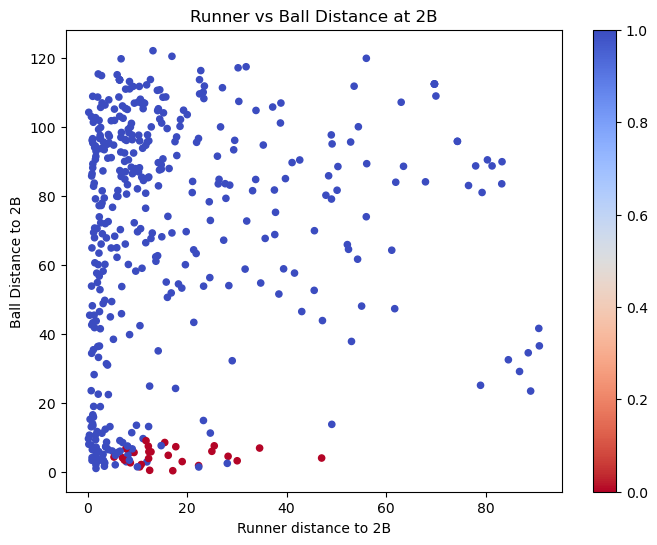

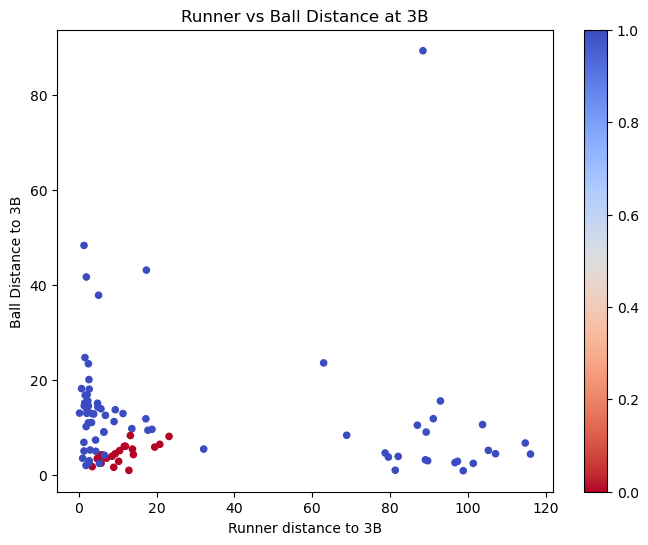

In [29]:
ax = tag_10_2B.plot.scatter(x = 'runner_10_dist_to_2B', y = 'ball_dist_to_2B', c = tag_10_2B['runner_10_safe_2B'].astype(int), colormap = 'coolwarm_r', figsize = (8,6))
ax.set_xlabel('Runner distance to 2B')
ax.set_ylabel('Ball Distance to 2B')
ax.set_title('Runner vs Ball Distance at 2B')
plt.show()

ax = tag_11_3B.plot.scatter(x = 'runner_11_dist_to_3B', y = 'ball_dist_to_3B', c = tag_11_3B['runner_11_safe_3B'].astype(int), colormap = 'coolwarm_r', figsize = (8,6))
ax.set_xlabel('Runner distance to 3B')
ax.set_ylabel('Ball Distance to 3B')
ax.set_title('Runner vs Ball Distance at 3B')
plt.show()

In [30]:
# ----- Merge all above datasets ----- #
ball_acquired_of = ball_acquired_of.merge(tag_10_2B[['game_str', 'play_id', 'runner_10_safe_2B']], on=['game_str', 'play_id'], how='left')
ball_acquired_of = ball_acquired_of.merge(tag_10_3B[['game_str', 'play_id', 'runner_10_safe_3B']], on=['game_str', 'play_id'], how='left')
ball_acquired_of = ball_acquired_of.merge(tag_11_3B[['game_str', 'play_id', 'runner_11_safe_3B']], on=['game_str', 'play_id'], how='left')
ball_acquired_of = ball_acquired_of.merge(tag_11_H[['game_str', 'play_id', 'runner_11_safe_Home']], on=['game_str', 'play_id'], how='left')
ball_acquired_of = ball_acquired_of.merge(tag_12_H[['game_str', 'play_id', 'runner_12_safe_Home']], on=['game_str', 'play_id'], how='left')


# ----- Fill missing safes with True if runner attempted but wasn't targeted ----- #
fill_safe_cols = [
    ('runner_11_attempt_3B', 'runner_11_safe_3B'),
    ('runner_11_attempt_Home', 'runner_11_safe_Home'),
    ('runner_12_attempt_Home', 'runner_12_safe_Home'),
    ('runner_10_attempt_2B', 'runner_10_safe_2B'),
    ('runner_10_attempt_3B', 'runner_10_safe_3B')
]

# ------ Fill new columns for each basepath variation and whether or not the runner was safe ------ #
for attempt_col, safe_col in fill_safe_cols:
    ball_acquired_of[safe_col] = ball_acquired_of.apply(
        lambda row: True if row.get(attempt_col) and pd.isna(row.get(safe_col)) else row.get(safe_col),
        axis=1
    )


ball_acquired_of

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,position,play_type,is_out,outs,non_play,field_x_1,field_x_2,field_x_3,field_x_4,field_x_5,field_x_6,field_x_7,field_x_8,field_x_9,field_x_10,field_x_11,field_x_12,field_x_13,field_x_14,field_x_15,field_x_16,field_x_17,field_x_18,field_x_19,field_y_1,field_y_2,field_y_3,field_y_4,field_y_5,field_y_6,field_y_7,field_y_8,field_y_9,field_y_10,field_y_11,field_y_12,field_y_13,field_y_14,field_y_15,field_y_16,field_y_17,field_y_18,field_y_19,ball_position_x,ball_position_y,ball_position_z,runner_10_attempt_2B,runner_10_attempt_3B,runner_11_attempt_3B,runner_11_attempt_Home,runner_12_attempt_Home,runner_10_safe_2B,runner_10_safe_3B,runner_11_safe_3B,runner_11_safe_Home,runner_12_safe_Home
0,y1_d001_CGA_QEA,108,20,108,4098455,8,2,QEA,CGA,top,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,center field,ball acquired,False,1,False,10.6242,1.8981,14.3628,41.7405,-54.0183,15.2175,-110.8791,94.4808,65.4084,35.7615,-44.5356,-62.0019,5.1159,NaN,NaN,-14.2134,NaN,NaN,NaN,-8.5950,3.9579,90.6048,194.3859,61.8522,145.7340,230.5518,338.4810,291.4254,110.5899,100.8936,65.0769,-6.6138,NaN,NaN,82.6446,NaN,NaN,NaN,95.34480,339.4440,0.000000,True,True,True,True,True,True,True,True,True,True
1,y1_d001_CGA_QEA,114,21,114,4231155,9,2,QEA,CGA,top,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1353,CGA-1824,CGA-1929,CGA-1592,right field,ball acquired,False,1,False,10.5693,1.1388,37.5054,25.8921,-49.8090,-15.0987,-121.0008,28.4658,139.5966,61.1802,NaN,NaN,-62.1426,NaN,105.7353,NaN,NaN,80.1735,NaN,29.4282,-4.7436,67.8333,137.6235,75.4221,101.4882,236.3949,327.7230,299.0814,61.2882,NaN,NaN,61.9074,NaN,136.4676,NaN,NaN,61.2753,NaN,138.17340,295.9152,5.194530,True,False,False,False,False,True,NaN,NaN,NaN,NaN
2,y1_d001_CGA_QEA,216,49,216,8333280,9,2,QEA,CGA,top,QEA-0152,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1929,CGA-1592,CGA-1547,NA,right field,ball acquired,False,1,False,-11.5893,0.7209,54.6249,86.6613,-62.0220,11.6007,-119.2062,-29.9289,188.1207,56.9868,NaN,-50.5641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.6054,-2.2872,67.4337,163.7433,80.8035,132.4140,233.3106,274.1229,245.4093,46.3326,NaN,38.5989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,188.00880,246.3627,0.000000,True,False,False,False,True,False,NaN,NaN,NaN,True
3,y1_d002_CGA_QEA,92,20,92,3087421,7,2,QEA,CGA,bottom,CGA-2074,CGA-1127,CGA-1592,CGA-1824,CGA-1198,CGA-2010,CGA-1353,CGA-1458,CGA-1547,QEA-0252,QEA-0235,QEA-0120,NA,left field,ball acquired,False,0,False,-13.9494,-1.2843,52.2426,-4.0035,-54.6465,-55.6794,-200.5506,-61.6011,113.8962,57.1884,-6.3957,-57.1140,NaN,NaN,NaN,-18.6291,NaN,69.7533,-59.1864,44.5128,-2.1459,67.1742,129.3156,74.8638,140.5182,236.1000,276.9882,207.5649,47.2554,122.2593,67.5888,NaN,NaN,NaN,92.0280,NaN,61.1097,41.8479,-201.44550,237.1629,0.000000,True,False,True,False,True,True,NaN,True,NaN,True
4,y1_d002_CGA_QEA,99,21,99,3366171,9,2,QEA,CGA,bottom,CGA-2074,CGA-1127,CGA-1592,CGA-1824,CGA-1198,CGA-2010,CGA-1353,CGA-1458,CGA-1547,QEA-0263,NA,QEA-0252,QEA-0235,right field,ball acquired,False,0,False,-1.6434,-0.3699,45.3174,55.3470,-61.3548,-21.3045,-132.2520,2.4126,150.7599,36.5151,12.8382,NaN,-20.8230,NaN,53.6865,-18.7200,-112.3923,68.8656,-64.2873,32.5035,-6.1887,63.3072,133.9908,65.0082,116.0889,244.0428,290.4192,178.6944,27.3090,121.6398,NaN,18.2217,NaN,71.4021,87.4467,93.5823,55.6809,54.0930,150.40560,177.5004,0.000000,False,False,True,False,False,NaN,NaN,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

### Determining Fielder Arm Strength

In [31]:
# ----- Function to calculate individual play arm strength (mph & ft/s) ----- #
# ----- Calculate velocity out of the hand, the distance between the first two timestamps of the outfielder's throw ----- #

def calculate_arm_strength(df):
    results = []

    for (game_str, play_id), group in df.groupby(['game_str', 'play_id']):
        group = group.sort_values(by='timestamp').reset_index(drop=True)
        
        # ----- temporary filtered dataset for throws by an outfielder ----- #
        of_throw = group[(group['event_code'] == 3) & (group['player_position'].isin([7, 8, 9]))]
        if of_throw.empty:
            continue

        # ----- Identify the timestamp where the throw begins ----- #
        throw_row = of_throw.iloc[0]
        t_throw = throw_row['timestamp']
        
        ball_positions = group[group['timestamp'] >= t_throw][
            ['timestamp', 'ball_position_x', 'ball_position_y']
        ].dropna().sort_values('timestamp').reset_index(drop=True)

        if len(ball_positions) < 2:
            continue # need 2 timestamps to calculate velo

        # ----- Identify 1st and 2nd timestamp, ball_pos_x and ball_pos_y out of the hand ----- #
        t1 = ball_positions.iloc[0]['timestamp']
        x1 = ball_positions.iloc[0]['ball_position_x']
        y1 = ball_positions.iloc[0]['ball_position_y']

        t2 = ball_positions.iloc[1]['timestamp']
        x2 = ball_positions.iloc[1]['ball_position_x']
        y2 = ball_positions.iloc[1]['ball_position_y']

        dt = t2 - t1 
        if dt <= 0:
            continue  
    
        # ----- calculate distance & velocity metrics ----- #
        distance = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)  
        velo_ft_per_s = distance / (dt / 1000) 
        velo_mph = velo_ft_per_s * 0.681818 

        results.append({
            'game_str': game_str,
            'play_id': play_id,
            'thrower_position': throw_row['player_position'],
            'time_of_throw': t_throw,
            'distance': distance,
            'dt_ms': dt,
            'arm_strength_ft_per_s': velo_ft_per_s,
            'arm_strength_mph': velo_mph
        })

    return pd.DataFrame(results)

# ----- Apply to full_plays_att dataset because of the abundance of positional data by timestamp ----- #
arm_strength_test = calculate_arm_strength(full_plays_att)

arm_strength = arm_strength_test[['game_str', 'play_id', 'arm_strength_mph']]
arm_strength.sort_values(by = 'play_id', ascending = True)

# ----- Calculate mean arm strength (mph) ----- #
arm_strength_mean = arm_strength['arm_strength_mph'].mean()
print("Average Arm Strength (MPH):")
print(arm_strength_mean)

arm_strength.sort_values(by='arm_strength_mph', ascending = False)

Average Arm Strength (MPH):
57.59828221351727


,game_str,play_id,arm_strength_mph
2019,y2_d092_NYA_YJD,260,89.282749
1533,y2_d036_UKI_RZQ,260,86.951536
1851,y2_d072_XFE_RZQ,279,84.845216
526,y1_d055_APZ_QEA,114,82.801866
896,y1_d079_PVJ_RZQ,137,82.616428
...,...,...,...
648,y1_d061_HCI_RZQ,136,6.157351
1237,y2_d009_JMJ_YJD,34,5.099356
2043,y2_d095_QZE_RZQ,11,2.711055
1749,y2_d065_ESW_YJD,40,1.055647


In [32]:
# ----- Merge arm_strength onto ball_acquired dataframe ----- #
ball_with_arm_strength = ball_acquired_of.merge(arm_strength, on = ['game_str', 'play_id'], how = 'inner') #Inner to eliminate plays where the velocity couldn't be calculated

ball_with_arm_strength

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,position,play_type,is_out,outs,non_play,field_x_1,field_x_2,field_x_3,field_x_4,field_x_5,field_x_6,field_x_7,field_x_8,field_x_9,field_x_10,field_x_11,field_x_12,field_x_13,field_x_14,field_x_15,field_x_16,field_x_17,field_x_18,field_x_19,field_y_1,field_y_2,field_y_3,field_y_4,field_y_5,field_y_6,field_y_7,field_y_8,field_y_9,field_y_10,field_y_11,field_y_12,field_y_13,field_y_14,field_y_15,field_y_16,field_y_17,field_y_18,field_y_19,ball_position_x,ball_position_y,ball_position_z,runner_10_attempt_2B,runner_10_attempt_3B,runner_11_attempt_3B,runner_11_attempt_Home,runner_12_attempt_Home,runner_10_safe_2B,runner_10_safe_3B,runner_11_safe_3B,runner_11_safe_Home,runner_12_safe_Home,arm_strength_mph
0,y1_d001_CGA_QEA,108,20,108,4098455,8,2,QEA,CGA,top,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,center field,ball acquired,False,1,False,10.6242,1.8981,14.3628,41.7405,-54.0183,15.2175,-110.8791,94.4808,65.4084,35.7615,-44.5356,-62.0019,5.1159,NaN,NaN,-14.2134,NaN,NaN,NaN,-8.5950,3.9579,90.6048,194.3859,61.8522,145.7340,230.5518,338.4810,291.4254,110.5899,100.8936,65.0769,-6.6138,NaN,NaN,82.6446,NaN,NaN,NaN,95.34480,339.4440,0.000000,True,True,True,True,True,True,True,True,True,True,58.470382
1,y1_d001_CGA_QEA,114,21,114,4231155,9,2,QEA,CGA,top,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1353,CGA-1824,CGA-1929,CGA-1592,right field,ball acquired,False,1,False,10.5693,1.1388,37.5054,25.8921,-49.8090,-15.0987,-121.0008,28.4658,139.5966,61.1802,NaN,NaN,-62.1426,NaN,105.7353,NaN,NaN,80.1735,NaN,29.4282,-4.7436,67.8333,137.6235,75.4221,101.4882,236.3949,327.7230,299.0814,61.2882,NaN,NaN,61.9074,NaN,136.4676,NaN,NaN,61.2753,NaN,138.17340,295.9152,5.194530,True,False,False,False,False,True,NaN,NaN,NaN,NaN,56.607167
2,y1_d001_CGA_QEA,216,49,216,8333280,9,2,QEA,CGA,top,QEA-0152,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1929,CGA-1592,CGA-1547,NA,right field,ball acquired,False,1,False,-11.5893,0.7209,54.6249,86.6613,-62.0220,11.6007,-119.2062,-29.9289,188.1207,56.9868,NaN,-50.5641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.6054,-2.2872,67.4337,163.7433,80.8035,132.4140,233.3106,274.1229,245.4093,46.3326,NaN,38.5989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,188.00880,246.3627,0.000000,True,False,False,False,True,False,NaN,NaN,NaN,True,67.167101
3,y1_d002_CGA_QEA,92,20,92,3087421,7,2,QEA,CGA,bottom,CGA-2074,CGA-1127,CGA-1592,CGA-1824,CGA-1198,CGA-2010,CGA-1353,CGA-1458,CGA-1547,QEA-0252,QEA-0235,QEA-0120,NA,left field,ball acquired,False,0,False,-13.9494,-1.2843,52.2426,-4.0035,-54.6465,-55.6794,-200.5506,-61.6011,113.8962,57.1884,-6.3957,-57.1140,NaN,NaN,NaN,-18.6291,NaN,69.7533,-59.1864,44.5128,-2.1459,67.1742,129.3156,74.8638,140.5182,236.1000,276.9882,207.5649,47.2554,122.2593,67.5888,NaN,NaN,NaN,92.0280,NaN,61.1097,41.8479,-201.44550,237.1629,0.000000,True,False,True,False,True,True,NaN,True,NaN,True,62.909130
4,y1_d002_CGA_QEA,99,21,99,3366171,9,2,QEA,CGA,bottom,CGA-2074,CGA-1127,CGA-1592,CGA-1824,CGA-1198,CGA-2010,CGA-1353,CGA-1458,CGA-1547,QEA-0263,NA,QEA-0252,QEA-0235,right field,ball acquired,False,0,False,-1.6434,-0.3699,45.3174,55.3470,-61.3548,-21.3045,-132.2520,2.4126,150.7599,36.5151,12.8382,NaN,-20.8230,NaN,53.6865,-18.7200,-112.3923,68.8656,-64.2873,32.5035,-6.1887,63.3072,133.9908,65.0082,116.0889,244.0428,290.4192,178.6944,27.3090,121.6398,NaN,18.2217,NaN,71.4021,87.4467,93.5823,55.6809,54.0930,150.40560,177.5004,0.000000,False,False,True,False,False,NaN,NaN,True,NaN,NaN,72.831981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

### Calculating Arm Strength Per Individual Player

In [33]:
ball_with_arm_strength['fielding_team'] = np.nan

# ----- Code to assign an arm strength to each outfield position of every team ----- #
# ----- Attempting to replicate assignment on an individual player basis ----- #

def add_fielding_team(row):
    
    # ----- Assign a fielding team ----- #
    if row['top_bottom_inning'] == 'top':
        row['fielding_team'] = row['home_team']
    else:
        row['fielding_team'] = row['away_team']
    
    return row

temp = ball_with_arm_strength.apply(add_fielding_team, axis=1)

# ----- Return the max arm strength demonstrated by each player for each team ----- #
individual_arm_strength = temp.groupby(['fielding_team', 'player_position'])[['arm_strength_mph']].max().reset_index()

# ----- Calculate the league averages for each position ----- #
# ----- Different outfield positions tend to exhibit stronger arm strengths ----- #
league_averages = (
    individual_arm_strength[individual_arm_strength['player_position'].isin([7, 8, 9])]
    .groupby('player_position')['arm_strength_mph']
    .mean()
    .to_dict()
)

# ----- Create list of teams and players regardless of any absence of data ----- #
teams = individual_arm_strength['fielding_team'].unique()
positions = [7, 8, 9]
full_index = pd.MultiIndex.from_product([teams, positions], names=['fielding_team', 'player_position'])

# ----- Sets multi-column index for fielding team and player position, and reindexes, filling empty with NaN ----- #
individual_arm_strength = (
    individual_arm_strength
    .set_index(['fielding_team', 'player_position'])
    .reindex(full_index)
    .reset_index()
)

# ----- Fill NaNs, or instances where max arm strength < 50 mph, in above dataset, with league average arm strength (mph) ----- #
individual_arm_strength['arm_strength_mph'] = individual_arm_strength.apply(
    lambda row: league_averages.get(row['player_position']) if (pd.isna(row['arm_strength_mph']) | (row['arm_strength_mph'] <= 50)) else row['arm_strength_mph'],
    axis=1
)

# ----- Standardize arm strength to 100 in "as+" statistic ----- #
individual_arm_strength['as+'] = individual_arm_strength.apply(
    lambda row: 100 * (row['arm_strength_mph'] / league_averages[row['player_position']]),
    axis=1
).round(1)
        
individual_arm_strength.sort_values(by = 'arm_strength_mph', ascending = False)

,fielding_team,player_position,arm_strength_mph,as+
118,NYA,8,89.282749,136.0
151,RZQ,8,84.845216,129.3
11,APZ,9,82.801866,120.8
152,RZQ,9,82.616428,120.5
28,DYE,8,82.531263,125.7
...,...,...,...,...
44,GHD,9,53.695459,78.3
62,IAQ,9,52.715228,76.9
102,LFS,7,52.113605,78.5
153,STK,7,51.823065,78.0


In [34]:
# ----- Merge back into larger dataset ----- #
ball_arms = temp.merge(individual_arm_strength, on = ['fielding_team', 'player_position'], how = 'inner')
ball_arms = ball_arms.drop(columns = 'arm_strength_mph_y').rename(columns =  {'arm_strength_mph_x':'arm_strength_mph'})
ball_arms

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,position,play_type,is_out,outs,non_play,field_x_1,field_x_2,field_x_3,field_x_4,field_x_5,field_x_6,field_x_7,field_x_8,field_x_9,field_x_10,field_x_11,field_x_12,field_x_13,field_x_14,field_x_15,field_x_16,field_x_17,field_x_18,field_x_19,field_y_1,field_y_2,field_y_3,field_y_4,field_y_5,field_y_6,field_y_7,field_y_8,field_y_9,field_y_10,field_y_11,field_y_12,field_y_13,field_y_14,field_y_15,field_y_16,field_y_17,field_y_18,field_y_19,ball_position_x,ball_position_y,ball_position_z,runner_10_attempt_2B,runner_10_attempt_3B,runner_11_attempt_3B,runner_11_attempt_Home,runner_12_attempt_Home,runner_10_safe_2B,runner_10_safe_3B,runner_11_safe_3B,runner_11_safe_Home,runner_12_safe_Home,arm_strength_mph,fielding_team,as+
0,y1_d001_CGA_QEA,108,20,108,4098455,8,2,QEA,CGA,top,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,center field,ball acquired,False,1,False,10.6242,1.8981,14.3628,41.7405,-54.0183,15.2175,-110.8791,94.4808,65.4084,35.7615,-44.5356,-62.0019,5.1159,NaN,NaN,-14.2134,NaN,NaN,NaN,-8.5950,3.9579,90.6048,194.3859,61.8522,145.7340,230.5518,338.4810,291.4254,110.5899,100.8936,65.0769,-6.6138,NaN,NaN,82.6446,NaN,NaN,NaN,95.34480,339.4440,0.000000,True,True,True,True,True,True,True,True,True,True,58.470382,QEA,115.5
1,y1_d001_CGA_QEA,114,21,114,4231155,9,2,QEA,CGA,top,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1353,CGA-1824,CGA-1929,CGA-1592,right field,ball acquired,False,1,False,10.5693,1.1388,37.5054,25.8921,-49.8090,-15.0987,-121.0008,28.4658,139.5966,61.1802,NaN,NaN,-62.1426,NaN,105.7353,NaN,NaN,80.1735,NaN,29.4282,-4.7436,67.8333,137.6235,75.4221,101.4882,236.3949,327.7230,299.0814,61.2882,NaN,NaN,61.9074,NaN,136.4676,NaN,NaN,61.2753,NaN,138.17340,295.9152,5.194530,True,False,False,False,False,True,NaN,NaN,NaN,NaN,56.607167,QEA,109.8
2,y1_d001_CGA_QEA,216,49,216,8333280,9,2,QEA,CGA,top,QEA-0152,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1929,CGA-1592,CGA-1547,NA,right field,ball acquired,False,1,False,-11.5893,0.7209,54.6249,86.6613,-62.0220,11.6007,-119.2062,-29.9289,188.1207,56.9868,NaN,-50.5641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.6054,-2.2872,67.4337,163.7433,80.8035,132.4140,233.3106,274.1229,245.4093,46.3326,NaN,38.5989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,188.00880,246.3627,0.000000,True,False,False,False,True,False,NaN,NaN,NaN,True,67.167101,QEA,109.8
3,y1_d002_CGA_QEA,92,20,92,3087421,7,2,QEA,CGA,bottom,CGA-2074,CGA-1127,CGA-1592,CGA-1824,CGA-1198,CGA-2010,CGA-1353,CGA-1458,CGA-1547,QEA-0252,QEA-0235,QEA-0120,NA,left field,ball acquired,False,0,False,-13.9494,-1.2843,52.2426,-4.0035,-54.6465,-55.6794,-200.5506,-61.6011,113.8962,57.1884,-6.3957,-57.1140,NaN,NaN,NaN,-18.6291,NaN,69.7533,-59.1864,44.5128,-2.1459,67.1742,129.3156,74.8638,140.5182,236.1000,276.9882,207.5649,47.2554,122.2593,67.5888,NaN,NaN,NaN,92.0280,NaN,61.1097,41.8479,-201.44550,237.1629,0.000000,True,False,True,False,True,True,NaN,True,NaN,True,62.909130,CGA,94.7
4,y1_d002_CGA_QEA,99,21,99,3366171,9,2,QEA,CGA,bottom,CGA-2074,CGA-1127,CGA-1592,CGA-1824,CGA-1198,CGA-2010,CGA-1353,CGA-1458,CGA-1547,QEA-0263,NA,QEA-0252,QEA-0235,right field,ball acquired,False,0,False,-1.6434,-0.3699,45.3174,55.3470,-61.3548,-21.3045,-132.2520,2.4126,150.7599,36.5151,12.8382,NaN,-20.8230,NaN,53.6865,-18.7200,-112.3923,68.8656,-64.2873,32.5035,-6.1887,63.3072,133.9908,65.0082,116.0889,244.0428,290.4192,178.6944,27.3090,121.6398,NaN,18.2217,NaN,71.4021,87.4467,93.5823,55.6809,54.0930,150.40560,177.5004,0.000000,False,False,True,False,False,NaN,NaN,True,NaN,NaN,72.831981,CGA,106.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [35]:
# ----- Define columns to retain when reshaping the DataFrame to long format ----- #
id_vars = [
    'game_str', 'play_id', 'timestamp', 'player_position', 'position', 'play_type',
    'home_team', 'away_team', 'top_bottom_inning', 'fielding_team', 'pitcher', 'catcher', 'first_base',
    'second_base', 'third_base', 'shortstop', 'left_field', 'center_field', 'right_field',
    'batter', 'first_baserunner', 'second_baserunner', 'third_baserunner', 'field_x_7', 'field_y_7',
    'field_x_8', 'field_y_8', 'field_x_9', 'field_y_9',
    'field_x_10', 'field_y_10', 'field_x_11', 'field_y_11', 'field_x_12', 'field_y_12',
    'ball_position_x', 'ball_position_y', 'ball_position_z', 
    'arm_strength_mph', 'as+'
]

# ----- Define runner movement attempt columns and their metadata ----- #
runner_cols = [
    ('runner_10_attempt_2B', 'runner_10_safe_2B', 10, 'Home', '2B'),
    ('runner_10_attempt_3B', 'runner_10_safe_3B', 10, 'Home', '3B'),
    ('runner_11_attempt_3B', 'runner_11_safe_3B', 11, '1B', '3B'),
    ('runner_11_attempt_Home', 'runner_11_safe_Home', 11, '1B', 'Home'),
    ('runner_12_attempt_Home', 'runner_12_safe_Home', 12, '2B', 'Home')
]

# ----- Iterate through the DataFrame and reshape based on runner attempts ----- #
long_rows = []

for _, row in ball_arms.iterrows():
    for attempt_col, safe_col, runner_id, from_base, to_base in runner_cols:
        if attempt_col in row and row[attempt_col] is True:
            
            # Copy key data fields to preserve play context
            long_row = row[id_vars].to_dict()
            
            # Add runner-specific info for this attempted advance
            long_row.update({
                'runner_id': runner_id,
                'from_base': from_base,
                'to_base': to_base,
                'attempted': row[attempt_col],
                'was_safe': row.get(safe_col, None),
                'runner_x': row.get(f'field_x_{runner_id}', None),
                'runner_y': row.get(f'field_y_{runner_id}', None)
            })
            long_rows.append(long_row)

ball_acquired_long = pd.DataFrame(long_rows)

ball_acquired_long

,game_str,play_id,timestamp,player_position,position,play_type,home_team,away_team,top_bottom_inning,fielding_team,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,field_x_7,field_y_7,field_x_8,field_y_8,field_x_9,field_y_9,field_x_10,field_y_10,field_x_11,field_y_11,field_x_12,field_y_12,ball_position_x,ball_position_y,ball_position_z,arm_strength_mph,as+,runner_id,from_base,to_base,attempted,was_safe,runner_x,runner_y
0,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,-110.8791,230.5518,94.4808,338.4810,65.4084,291.4254,35.7615,110.5899,-44.5356,100.8936,-62.0019,65.0769,95.34480,339.4440,0.000000,58.470382,115.5,10,Home,2B,True,True,35.7615,110.5899
1,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,-110.8791,230.5518,94.4808,338.4810,65.4084,291.4254,35.7615,110.5899,-44.5356,100.8936,-62.0019,65.0769,95.34480,339.4440,0.000000,58.470382,115.5,10,Home,3B,True,True,35.7615,110.5899
2,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,-110.8791,230.5518,94.4808,338.4810,65.4084,291.4254,35.7615,110.5899,-44.5356,100.8936,-62.0019,65.0769,95.34480,339.4440,0.000000,58.470382,115.5,11,1B,3B,True,True,-44.5356,100.8936
3,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,-110.8791,230.5518,94.4808,338.4810,65.4084,291.4254,35.7615,110.5899,-44.5356,100.8936,-62.0019,65.0769,95.34480,339.4440,0.000000,58.470382,115.5,11,1B,Home,True,True,-44.5356,100.8936
4,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,-110.8791,230.5518,94.4808,338.4810,65.4084,291.4254,35.7615,110.5899,-44.5356,100.8936,-62.0019,65.0769,95.34480,339.4440,0.000000,58.470382,115.5,12,2B,Home,True,True,-62.0019,65.0769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1616,y2_d097_YJD_RZQ,135,4577967,9,right field,ball acquired,RZQ,YJD,top,RZQ,RZQ-0324,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0304,YJD-0185,NA,NA,-96.7185,255.9393,39.2322,280.7097,133.2096,160.6026,59.9400,76.3764,-44.4399,96.9873,NaN,NaN,133.39500,160.2150,0.000000,46.345513,120.5,11,1B,3B,True,True,-44.4399,96.9873
1617,y2_d097_YJD_RZQ,158,5464867,7,left field,ball acquired,RZQ,YJD,top,RZQ,RZQ-0324,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0019,YJD-0373,NA,NA,-215.7858,218.5887,-45.8652,275.4750,119.8926,214.4736,46.7868,97.4673,-52.2138,90.8238,NaN,NaN,-217.27050,217.1076,-0.619500,66.982527,121.2,10,Home,2B,True,True,46.7868,97.4673
1618,y2_d097_YJD_RZQ,158,5464867,7,left field,ball acquired,RZQ,YJD,top,RZQ,RZQ-0324,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0019,YJD-0373,NA,NA,-215.7858,218.5887,-45.8652,275.4750,119.8926,214.4736,46.7868,97.4673,-52.2138,90.8238,NaN,NaN,-217.27050,217.1076,-0.619500,66.982527,121.2,11,1B,3B,True,True,-52.2138,90.8238
1619,y2_d097_YJD_RZQ,158,5464867,7,left field,ball acquired,RZQ,YJD,top,RZQ,RZQ-0324,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0019,YJD-0373,NA,NA,-215.7858,218.5887,-45.8652,275.4750,119.8926,214.4736,46.7868,97.4673,-52.2138,90.8238,NaN,NaN,-217.27050,217.1076,-0.619500,66.982

### Safe/Out Distribution

In [36]:
ball_acquired_long['was_safe'].value_counts()

was_safe
True     1529
False      92
Name: count, dtype: int64

### Calculate Outfielder_Distance_to_Base & Runner_Distance_to_Base features

In [37]:
base_coords = {
    '3B': (-63.64, 63.64),
    'Home': (0, 0),
    '2B': (0, 127)
}


# ----- Calculate Runner_Distance_to_Base ----- #

# ----- Find runner distance from the target base ----- #
def compute_runner_dist(row):

    bx, by = base_coords.get(row['to_base'], (np.nan, np.nan))
    return np.sqrt((row['runner_x'] - bx)**2 + (row['runner_y'] - by)**2)

ball_acquired_long['runner_dist_to_base'] = ball_acquired_long.apply(compute_runner_dist, axis=1)



# ----- Calculate Outfielder_Distance_to_Base ----- #

# ----- Determine which fielder has the ball and find their location ----- #
def get_fielder_xy(row):

    pos_num = int(row['player_position'])
    field_x_col = f'field_x_{pos_num}'
    field_y_col = f'field_y_{pos_num}'
    return pd.Series({
        'fielder_x': row[field_x_col],
        'fielder_y': row[field_y_col]
    })

# ----- Add fielder coordinate data to larger dataset ----- #
ball_acquired_long[['fielder_x', 'fielder_y']] = ball_acquired_long.apply(get_fielder_xy, axis=1)

# ----- Computer fielder distance to runner's targeted base ----- #
def compute_fielder_dist(row):
    bx, by = base_coords.get(row['to_base'], (np.nan, np.nan))
    return np.sqrt((row['fielder_x'] - bx)**2 + (row['fielder_y'] - by)**2)

ball_acquired_long['fielder_dist_to_base'] = ball_acquired_long.apply(compute_fielder_dist, axis=1)
ball_acquired_long

,game_str,play_id,timestamp,player_position,position,play_type,home_team,away_team,top_bottom_inning,fielding_team,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,field_x_7,field_y_7,field_x_8,field_y_8,field_x_9,field_y_9,field_x_10,field_y_10,field_x_11,field_y_11,field_x_12,field_y_12,ball_position_x,ball_position_y,ball_position_z,arm_strength_mph,as+,runner_id,from_base,to_base,attempted,was_safe,runner_x,runner_y,runner_dist_to_base,fielder_x,fielder_y,fielder_dist_to_base
0,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,-110.8791,230.5518,94.4808,338.4810,65.4084,291.4254,35.7615,110.5899,-44.5356,100.8936,-62.0019,65.0769,95.34480,339.4440,0.000000,58.470382,115.5,10,Home,2B,True,True,35.7615,110.5899,39.346871,94.4808,338.4810,231.626499
1,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,-110.8791,230.5518,94.4808,338.4810,65.4084,291.4254,35.7615,110.5899,-44.5356,100.8936,-62.0019,65.0769,95.34480,339.4440,0.000000,58.470382,115.5,10,Home,3B,True,True,35.7615,110.5899,109.931576,94.4808,338.4810,317.080057
2,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,-110.8791,230.5518,94.4808,338.4810,65.4084,291.4254,35.7615,110.5899,-44.5356,100.8936,-62.0019,65.0769,95.34480,339.4440,0.000000,58.470382,115.5,11,1B,3B,True,True,-44.5356,100.8936,41.866560,94.4808,338.4810,317.080057
3,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,-110.8791,230.5518,94.4808,338.4810,65.4084,291.4254,35.7615,110.5899,-44.5356,100.8936,-62.0019,65.0769,95.34480,339.4440,0.000000,58.470382,115.5,11,1B,Home,True,True,-44.5356,100.8936,110.285712,94.4808,338.4810,351.419989
4,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,-110.8791,230.5518,94.4808,338.4810,65.4084,291.4254,35.7615,110.5899,-44.5356,100.8936,-62.0019,65.0769,95.34480,339.4440,0.000000,58.470382,115.5,12,2B,Home,True,True,-62.0019,65.0769,89.884584,94.4808,338.4810,351.419989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1616,y2_d097_YJD_RZQ,135,4577967,9,right field,ball acquired,RZQ,YJD,top,RZQ,RZQ-0324,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0304,YJD-0185,NA,NA,-96.7185,255.9393,39.2322,280.7097,133.2096,160.6026,59.9400,76.3764,-44.4399,96.9873,NaN,NaN,133.39500,160.2150,0.000000,46.345513,120.5,11,1B,3B,True,True,-44.4399,96.9873,38.479686,133.2096,160.6026,219.434525
1617,y2_d097_YJD_RZQ,158,5464867,7,left field,ball acquired,RZQ,YJD,top,RZQ,RZQ-0324,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0019,YJD-0373,NA,NA,-215.7858,218.5887,-45.8652,275.4750,119.8926,214.4736,46.7868,97.4673,-52.2138,90.8238,NaN,NaN,-217.27050,217.1076,-0.619500,66.982527,121.2,10,Home,2B,True,True,46.7868,97.4673,55.327977,-215.7858,218.5887,234.418432
1618,y2_d097_YJD_RZQ,158,5464867,7,left field,ball acquired,RZQ,YJD,top,RZQ,RZQ-0324,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0019,YJD-0373,NA,NA,-215.7858,218.5887,-45.8652,275.4750,119.8926,214.4736,46.7868,97.4673,-52.2138,90.8238,NaN,NaN,-217.27050,217.1076,-0.619500,66.982527,121.2,1

In [38]:
# ---- Filter attempts into respective datasets of each possible runner base to base combination ----- #
def filter_attempts(df, from_base, to_base):
    return df[(df['from_base'] == from_base) & (df['to_base'] == to_base)].copy()

attempts_H_2B = filter_attempts(ball_acquired_long, 'Home', '2B')
attempts_H_3B = filter_attempts(ball_acquired_long, 'Home', '3B')
attempts_1B_3B = filter_attempts(ball_acquired_long, '1B', '3B')
attempts_1B_Home = filter_attempts(ball_acquired_long, '1B', 'Home')
attempts_2B_Home = filter_attempts(ball_acquired_long, '2B', 'Home')


### Begin to Run Extra Base Safe Probability Model - Logistic Regression

In [39]:
# ----- Drop rows with empty features ----- #

# Not including arm_strength feature due to later model overfitting
features = ['runner_dist_to_base', 'fielder_dist_to_base']
attempts_1B_3B = attempts_1B_3B.dropna(subset=features)
label = 'was_safe'

# ----- Assign features and target variables ----- #
X_1B_3B = attempts_1B_3B[features]
y_1B_3B = attempts_1B_3B[label]

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss

# ----- Split up data into 80% training and 20% testing ----- #
X_train, X_test, y_train, y_test = train_test_split(X_1B_3B, y_1B_3B, test_size=0.2, random_state=12)


model = LogisticRegression(multi_class='ovr')
model.fit(X_train, y_train)

# ----- Predict probability of runner being safe ----- #
y_pred_proba = model.predict_proba(X_test)[:, 1]

# ----- Print Brier Score to evaluate our probability model ----- #
brier_score = brier_score_loss(y_test, y_pred_proba, pos_label=1)
print("Brier Score:", brier_score)


# ----- Assign to new column ----- #
attempts_1B_3B['safe_probability'] = model.predict_proba(X_1B_3B)[:, 1]

Brier Score: 0.027529100181643926


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


### Visualize feature relationships and brier score.

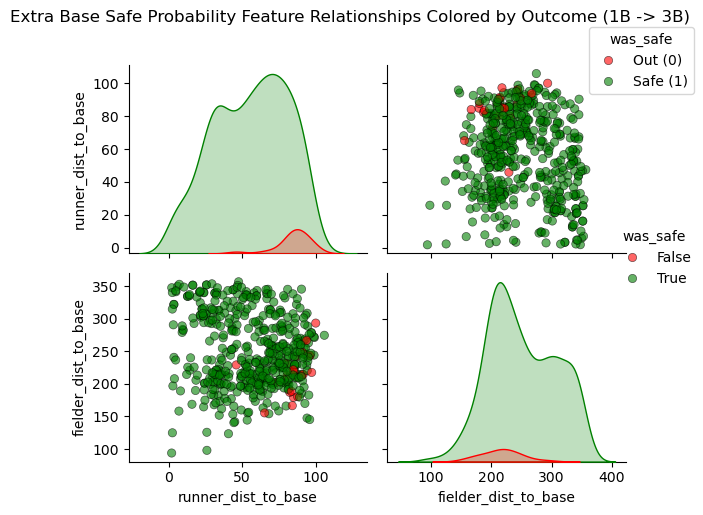

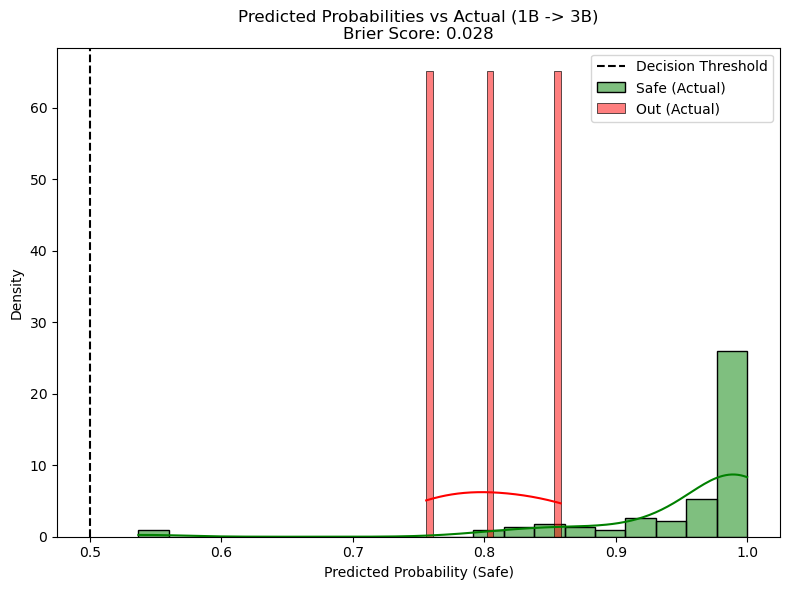

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# ----- Create the pairplot, comparing features to each other ------ #
pair = sns.pairplot(
    attempts_1B_3B,
    vars=features,
    hue='was_safe',
    palette={0: 'red', 1: 'green'},
    plot_kws={'alpha': 0.6, 'edgecolor': 'k'}
)

# Add a legend with proper labels
pair.fig.suptitle('Extra Base Safe Probability Feature Relationships Colored by Outcome (1B -> 3B)', y=1.02)

# Customize the legend
handles = pair._legend_data.values()
labels = ['Out (0)', 'Safe (1)']
pair.fig.legend(handles=handles, labels=labels, title='was_safe', loc='upper right', bbox_to_anchor=(1.1, 1))

# Plot the pairplot
plt.tight_layout()
plt.show()


# ----- Plot the performance of the brier score, predicted probabilities vs. actual ------ #
plt.figure(figsize=(8, 6))

# Plot two histograms, one for safe and one for out instances
sns.histplot(y_pred_proba[y_test == 1], bins=20, color='green', label='Safe (Actual)', stat='density', kde=True)
sns.histplot(y_pred_proba[y_test == 0], bins=20, color='red', label='Out (Actual)', stat='density', kde=True)

#Plot histograms
plt.axvline(0.5, color='black', linestyle='--', label='Decision Threshold')
plt.xlabel('Predicted Probability (Safe)')
plt.ylabel('Density')
plt.title(f'Predicted Probabilities vs Actual (1B -> 3B)\nBrier Score: {brier_score:.3f}')
plt.legend()
plt.tight_layout()
plt.show()



### For a Brier Score, 0 represents perfect accuracy and 1 represents complete inaccuracy. Our predicted probabilities model the true safe/out outcome pretty well!

### Now for the rest of the runner base to base combinations...

In [42]:
# ---- Repeat process for the other base to base combinations ----- #

# Home -> 2B
attempts_H_2B = attempts_H_2B.dropna(subset=features + [label])
X_H_2B = attempts_H_2B[features]
y_H_2B = attempts_H_2B[label]
X_train, X_test_H_2B, y_train, y_test_H_2B = train_test_split(X_H_2B, y_H_2B, test_size=0.2, random_state=12)
model_H_2B = LogisticRegression().fit(X_train, y_train)
print("H->2B Brief Score:", brier_score_loss(y_test_H_2B, model_H_2B.predict_proba(X_test_H_2B)[:, 1]))
attempts_H_2B['safe_probability'] = model_H_2B.predict_proba(X_H_2B)[:, 1]

# Home -> 3B
attempts_H_3B = attempts_H_3B.dropna(subset=features + [label])
X_H_3B = attempts_H_3B[features]
y_H_3B = attempts_H_3B[label]
X_train, X_test_H_3B, y_train, y_test_H_3B = train_test_split(X_H_3B, y_H_3B, test_size=0.2, random_state=12)
model_H_3B = LogisticRegression().fit(X_train, y_train)
print("H->3B Brier Score:", brier_score_loss(y_test_H_3B, model_H_3B.predict_proba(X_test_H_3B)[:, 1]))
attempts_H_3B['safe_probability'] = model_H_3B.predict_proba(X_H_3B)[:, 1]

# 1B -> 3B
attempts_1B_3B = attempts_1B_3B.dropna(subset=features + [label])
X_1B_3B = attempts_1B_3B[features]
y_1B_3B = attempts_1B_3B[label]
X_train, X_test_1B_3B, y_train, y_test_1B_3B = train_test_split(X_1B_3B, y_1B_3B, test_size=0.2, random_state=12)
model_1B_3B = LogisticRegression().fit(X_train, y_train)
print("1B->3B Brier Score:", brier_score_loss(y_test_1B_3B, model_1B_3B.predict_proba(X_test_1B_3B)[:, 1]))
attempts_1B_3B['safe_probability'] = model_1B_3B.predict_proba(X_1B_3B)[:, 1]

# 1B -> Home
attempts_1B_Home = attempts_1B_Home.dropna(subset=features + [label])
X_1B_Home = attempts_1B_Home[features]
y_1B_Home = attempts_1B_Home[label]
X_train, X_test_1B_H, y_train, y_test_1B_H = train_test_split(X_1B_Home, y_1B_Home, test_size=0.2, random_state=12)
model_1B_Home = LogisticRegression().fit(X_train, y_train)
print("1B->Home Brier Score:", brier_score_loss(y_test_1B_H, model_1B_Home.predict_proba(X_test_1B_H)[:, 1]))
attempts_1B_Home['safe_probability'] = model_1B_Home.predict_proba(X_1B_Home)[:, 1]

# 2B -> Home
attempts_2B_Home = attempts_2B_Home.dropna(subset=features + [label])
X_2B_Home = attempts_2B_Home[features]
y_2B_Home = attempts_2B_Home[label]
X_train, X_test_2B_H, y_train, y_test_2B_H = train_test_split(X_2B_Home, y_2B_Home, test_size=0.2, random_state=12)
model_2B_Home = LogisticRegression().fit(X_train, y_train)
print("2B->Home Brier Score:", brier_score_loss(y_test_2B_H, model_2B_Home.predict_proba(X_test_2B_H)[:, 1]))
attempts_2B_Home['safe_probability'] = model_2B_Home.predict_proba(X_2B_Home)[:, 1]

H->2B Brief Score: 0.01660157350354735
H->3B Brier Score: 0.03636659965109435
1B->3B Brier Score: 0.027529100181643926
1B->Home Brier Score: 0.09086091703064737
2B->Home Brier Score: 0.05400749887589232


In [43]:
# ----- Creating a brier score dataframe ----- #
brier_scores = {
    "Home → 2B": brier_score_loss(y_test_H_2B, model_H_2B.predict_proba(X_test_H_2B)[:, 1]),
    "Home → 3B": brier_score_loss(y_test_H_3B, model_H_3B.predict_proba(X_test_H_3B)[:, 1]),
    "1B → 3B":   brier_score_loss(y_test_1B_3B, model_1B_3B.predict_proba(X_test_1B_3B)[:, 1]),
    "1B → Home": brier_score_loss(y_test_1B_H, model_1B_Home.predict_proba(X_test_1B_H)[:, 1]),
    "2B → Home": brier_score_loss(y_test_2B_H, model_2B_Home.predict_proba(X_test_2B_H)[:, 1])
}

brier_df = pd.DataFrame.from_dict(brier_scores, orient='index', columns=['Brier Score'])
brier_df = brier_df.sort_values('Brier Score', ascending=True)
display(brier_df.style.background_gradient(cmap='coolwarm_r', axis=0).format("{:.3f}"))

,Brier Score
Home → 2B,0.017
1B → 3B,0.028
Home → 3B,0.036
2B → Home,0.054
1B → Home,0.091


### Our accuracy was much greater on plays at 2nd or 3rd base because we were able to see whether or not the batter or baserunners reached their targeted base, thanks to the dataset. 

### Plotting our brier score distribution.

/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_4462/1694861781.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


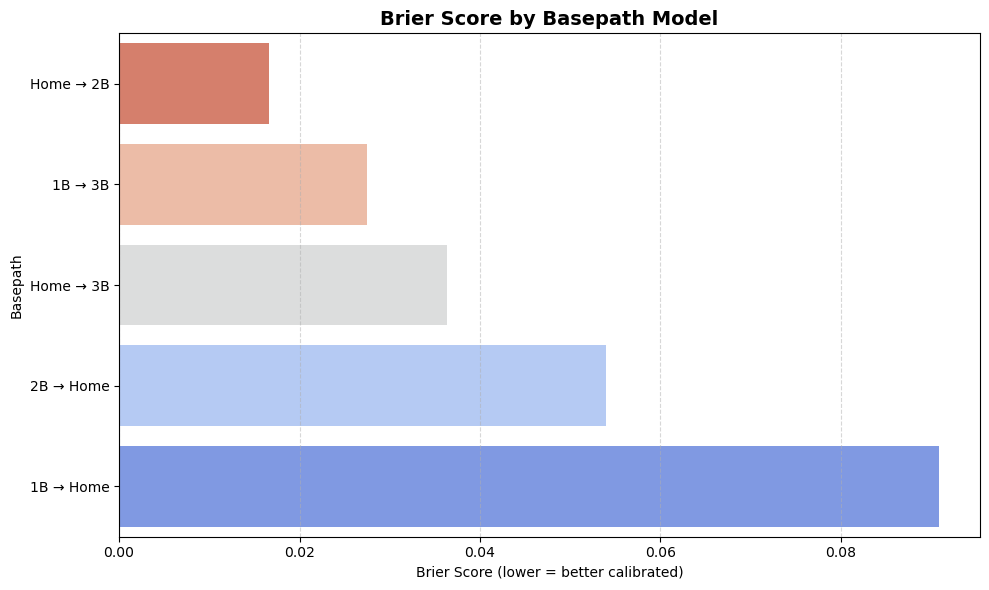

In [44]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x=brier_df['Brier Score'],
    y=brier_df.index,
    palette='coolwarm_r'
)

plt.title("Brier Score by Basepath Model", fontsize=14, fontweight='bold')
plt.xlabel("Brier Score (lower = better calibrated)")
plt.ylabel("Basepath")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### With these numbers, we can confirm high confidence in our extra base safe probability model.

In [45]:
# ----- Merging all datasets together to one final safe probability dataset ----- #

final_probs = pd.concat([
    attempts_H_2B,
    attempts_H_3B,
    attempts_1B_3B,
    attempts_1B_Home,
    attempts_2B_Home
], ignore_index=True)

final_probs.sample(10)

,game_str,play_id,timestamp,player_position,position,play_type,home_team,away_team,top_bottom_inning,fielding_team,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,field_x_7,field_y_7,field_x_8,field_y_8,field_x_9,field_y_9,field_x_10,field_y_10,field_x_11,field_y_11,field_x_12,field_y_12,ball_position_x,ball_position_y,ball_position_z,arm_strength_mph,as+,runner_id,from_base,to_base,attempted,was_safe,runner_x,runner_y,runner_dist_to_base,fielder_x,fielder_y,fielder_dist_to_base,safe_probability
353,y2_d027_YUH_RZQ,41,1213534,7,left field,ball acquired,RZQ,YUH,top,RZQ,RZQ-0324,RZQ-0169,RZQ-0333,RZQ-0347,RZQ-0040,RZQ-0355,RZQ-0231,RZQ-0310,RZQ-0346,YUH-1050,YUH-1729,NA,NA,-210.5484,210.0081,-45.0159,271.0794,94.9443,271.2201,61.5705,76.0260,-34.3389,110.4549,NaN,NaN,-213.6771,215.3967,-3.8676,67.777303,121.2,10,Home,2B,True,True,61.5705,76.0260,79.932942,-210.5484,210.0081,226.320510,0.953790
843,y2_d008_TSZ_RZQ,64,1678095,7,left field,ball acquired,RZQ,TSZ,top,RZQ,RZQ-0158,RZQ-0169,RZQ-0333,RZQ-0275,RZQ-0326,RZQ-0355,RZQ-0409,RZQ-0310,RZQ-0231,TSZ-2051,TSZ-1120,NA,NA,-191.2530,202.1637,-58.2381,272.0529,98.4495,258.0894,60.8052,60.8706,-26.9121,115.8213,NaN,NaN,-191.6760,202.3128,0.0000,60.856697,121.2,11,1B,3B,True,True,-26.9121,115.8213,63.810867,-191.2530,202.1637,188.345144,0.956111
66,y1_d037_HMN_RZQ,179,5755525,7,left field,ball acquired,RZQ,HMN,bottom,HMN,HMN-2446,HMN-2390,HMN-1594,HMN-1397,HMN-1106,HMN-1883,HMN-1633,HMN-1226,HMN-1212,RZQ-0381,NA,RZQ-0169,NA,-195.9501,219.6348,6.7710,288.1683,114.2544,221.9862,61.3551,62.8815,NaN,NaN,-50.2326,30.8220,-195.8592,219.9591,0.0000,70.348105,105.9,10,Home,2B,True,False,61.3551,62.8815,88.744748,-195.9501,219.6348,216.743276,0.912640
1443,y2_d009_JMJ_YJD,147,4500991,7,left field,ball acquired,YJD,JMJ,bottom,JMJ,JMJ-2085,JMJ-1059,JMJ-2007,JMJ-2130,JMJ-1175,JMJ-1299,JMJ-2220,JMJ-1419,JMJ-2042,YJD-0019,YJD-0278,YJD-0397,NA,-205.2501,204.0714,14.0001,293.9184,138.8916,217.7901,51.0531,96.0369,-51.7758,89.1012,-28.1031,18.8367,-206.1828,200.1747,0.0000,68.702460,103.5,12,2B,Home,True,True,-28.1031,18.8367,33.832019,-205.2501,204.0714,289.435208,0.999990
311,y2_d008_TSZ_RZQ,262,7637845,9,right field,ball acquired,RZQ,TSZ,bottom,TSZ,TSZ-2510,TSZ-2051,TSZ-1120,TSZ-2189,TSZ-1991,TSZ-1361,TSZ-1278,TSZ-1892,TSZ-2241,RZQ-0409,NA,RZQ-0355,NA,-118.1277,129.4815,13.8741,297.2379,214.1556,263.3286,4.6494,125.5692,NaN,NaN,0.5139,0.1062,212.7036,263.8299,-1.4175,59.491693,86.8,10,Home,2B,True,True,4.6494,125.5692,4.864577,214.1556,263.3286,253.866320,0.999855
124,y1_d050_JZK_RZQ,114,3898846,7,left field,ball acquired,RZQ,JZK,bottom,JZK,JZK-2296,JZK-1715,JZK-2451,JZK-1773,JZK-1925,JZK-1113,JZK-1011,JZK-1781,JZK-1356,RZQ-0059,RZQ-0381,RZQ-0333,NA,-202.1661,209.2362,-47.4294,277.0368,104.5146,170.3166,55.4037,86.7576,-55.1172,86.3226,-13.4202,8.4504,-204.3861,209.1579,-1.1307,65.265842,107.1,10,Home,2B,True,True,55.4037,86.7576,68.476425,-202.1661,209.2362,218.251975,0.980463
634,y1_d044_WJU_QEA,47,1242702,7,left field,ball acquired,QEA,WJU,bottom,WJU,WJU-1998,WJU-1224,WJU-1346,WJU-2325,WJU-1579,WJU-1386,WJU-2497,WJU-1348,WJU-1265,QEA-0263,NA,QEA-0071,QEA-0180,-108.0843,318.6969,-63.2082,341.5236,129.9165,245.7792,58.7334,55.7400,-23.6985,121.0113,-51.3882,42.1113,-105.0288,315.4500,0.0000,60.827569,99.8,11,1B,3B,True,True,-23.6985,121.0113,69.905575,-108.0843,318.6969,258.900209,0.980807
945,y2_d052_PTB_YJD,346,11092801,9,right field,ball acquired,YJD,PTB,bottom,PTB,PTB-1126,PTB-2064,PTB-2163,PTB-1234,PTB-1993,PTB-1363,PTB-1274,PTB-1280,PTB-1440,YJD-0185,YJD-0345,YJD-0304,NA,-119.2278,239.4465,-17.1615,283.0584,199.2123,257.9136,-8.3664,125.6010,-45.6108,28.2564,-5.8200,4.8390,197.0187,256.5810,-0.2610,60.630825,88.5,11,1B,3B,True,True,-45.6108,28.2564,39.712104,199.2123,257.9136,326.854040,0.999651
1118,y1_d073_UWE_YJD,202,6563682,9,right field,ball acquired,YJD,UWE,bottom,UWE,UWE-1366,UWE-

<Axes: title={'center': 'Safe Probability Distribution'}, ylabel='Frequency'>

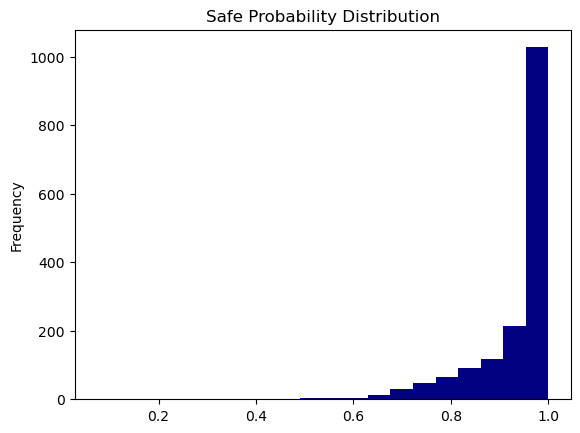

In [46]:
final_probs['safe_probability'].plot(kind='hist', bins=20, title='Safe Probability Distribution', color = 'navy')

# Step 3: Use Submodel to Determine Optimal Cutoff Actions

### We'll be focusing on three cutoff play possibilities:
###   -  Let the throw through, cut the throw and hold, or cut and throw to another base

### We need to include our calculated outs into our newest dataframe...

In [47]:
# ----- Prep outs dataframe to merged ------ #

with_outs = with_outs[['game_str', 'play_id', 'outs']]
with_outs_grouped = with_outs.groupby(['game_str', 'play_id', 'outs']).count().reset_index()
with_outs_grouped

,game_str,play_id,outs
0,y1_d001_CGA_QEA,1,0
1,y1_d001_CGA_QEA,2,0
2,y1_d001_CGA_QEA,3,0
3,y1_d001_CGA_QEA,4,0
4,y1_d001_CGA_QEA,5,0
...,...,...,...
83661,y2_d099_YJD_RZQ,289,1
83662,y2_d099_YJD_RZQ,290,1
83663,y2_d099_YJD_RZQ,291,1
83664,y2_d099_YJD_RZQ,292,1


In [48]:
# ------ Merge onto larger dataset and filter for plays with less than 3 outs ----- #
final_probs_outs = final_probs.merge(with_outs_grouped, on=['game_str', 'play_id'], how='left')
final_probs_outs = final_probs_outs[final_probs_outs['outs'] < 3]
final_probs_outs

,game_str,play_id,timestamp,player_position,position,play_type,home_team,away_team,top_bottom_inning,fielding_team,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,field_x_7,field_y_7,field_x_8,field_y_8,field_x_9,field_y_9,field_x_10,field_y_10,field_x_11,field_y_11,field_x_12,field_y_12,ball_position_x,ball_position_y,ball_position_z,arm_strength_mph,as+,runner_id,from_base,to_base,attempted,was_safe,runner_x,runner_y,runner_dist_to_base,fielder_x,fielder_y,fielder_dist_to_base,safe_probability,outs
0,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,-110.8791,230.5518,94.4808,338.4810,65.4084,291.4254,35.7615,110.5899,-44.5356,100.8936,-62.0019,65.0769,95.3448,339.4440,0.000000,58.470382,115.5,10,Home,2B,True,True,35.7615,110.5899,39.346871,94.4808,338.4810,231.626499,0.997912,1
1,y1_d001_CGA_QEA,114,4231155,9,right field,ball acquired,QEA,CGA,top,QEA,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1353,CGA-1824,CGA-1929,CGA-1592,-121.0008,236.3949,28.4658,327.7230,139.5966,299.0814,61.1802,61.2882,NaN,NaN,NaN,NaN,138.1734,295.9152,5.194530,56.607167,109.8,10,Home,2B,True,True,61.1802,61.2882,89.783392,139.5966,299.0814,221.583436,0.905948,1
2,y1_d001_CGA_QEA,216,8333280,9,right field,ball acquired,QEA,CGA,top,QEA,QEA-0152,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1929,CGA-1592,CGA-1547,NA,-119.2062,233.3106,-29.9289,274.1229,188.1207,245.4093,56.9868,46.3326,NaN,NaN,-50.5641,38.5989,188.0088,246.3627,0.000000,67.167101,109.8,10,Home,2B,True,False,56.9868,46.3326,98.766010,188.1207,245.4093,222.283963,0.827697,1
3,y1_d002_CGA_QEA,92,3087421,7,left field,ball acquired,QEA,CGA,bottom,CGA,CGA-2074,CGA-1127,CGA-1592,CGA-1824,CGA-1198,CGA-2010,CGA-1353,CGA-1458,CGA-1547,QEA-0252,QEA-0235,QEA-0120,NA,-200.5506,236.1000,-61.6011,276.9882,113.8962,207.5649,57.1884,47.2554,-6.3957,122.2593,-57.1140,67.5888,-201.4455,237.1629,0.000000,62.909130,94.7,10,Home,2B,True,True,57.1884,47.2554,98.131108,-200.5506,236.1000,228.305395,0.834470,0
4,y1_d003_CGA_QEA,92,3994106,9,right field,ball acquired,QEA,CGA,bottom,CGA,CGA-1302,CGA-1503,CGA-1592,CGA-1458,CGA-1166,CGA-2010,CGA-1824,CGA-1547,CGA-1198,QEA-0249,QEA-0365,NA,NA,-136.9167,241.8789,51.5217,335.9463,69.6903,327.1002,59.4930,72.1209,NaN,NaN,NaN,NaN,67.7784,325.8180,0.011808,65.544151,106.3,10,Home,2B,True,True,59.4930,72.1209,80.939068,69.6903,327.1002,211.888716,0.950335,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859,y2_d095_QZE_RZQ,97,2945498,7,left field,ball acquired,RZQ,QZE,bottom,QZE,QZE-2482,QZE-2394,QZE-1252,QZE-1479,QZE-2357,QZE-1888,QZE-2217,QZE-1638,QZE-2280,RZQ-0414,RZQ-0040,RZQ-0409,NA,-100.2816,242.7507,-29.2206,301.5186,117.9345,262.6098,23.4867,17.3817,10.9254,123.0792,-60.0858,78.1305,-100.0560,246.7371,1.275069,69.591611,118.6,12,2B,Home,True,True,-60.0858,78.1305,98.563068,-100.2816,242.7507,262.648628,0.799040,1
1860,y2_d095_QZE_RZQ,97,2945498,7,left field,ball acquired,RZQ,QZE,bottom,QZE,QZE-2482,QZE-2394,QZE-1252,QZE-1479,QZE-2357,QZE-1888,QZE-2217,QZE-1638,QZE-2280,RZQ-0414,RZQ-0040,RZQ-0409,NA,-100.2816,242.7507,-29.2206,301.5186,117.9345,262.6098,23.4867,17.3817,10.9254,123.0792,-60.0858,78.1305,-100.0560,246.7371,1.275069,69.591611,118.6,12,2B,Home,True,True,-60.0858,78.1305,98.563068,-100.2816,242.7507,262.648628,0.799040,2
1861,y2_d095_QZE_RZQ,143,4421598,9,right field,ball acquired,RZQ,QZE,top,RZQ,RZQ-0292,RZQ-0318,RZQ-0414,RZQ-0347,RZQ-0395,RZQ-0040,RZQ-0275,RZQ-0409,RZQ-0231,QZE-1252,NA,QZE-2394,NA,-87.6519,261.7596,72.1269,303.4920,97.3488,223.4940,40.7691,25.2489,NaN,Na

<Axes: title={'center': 'Safe Probability vs Cutoff'}, xlabel='outs', ylabel='safe_probability'>

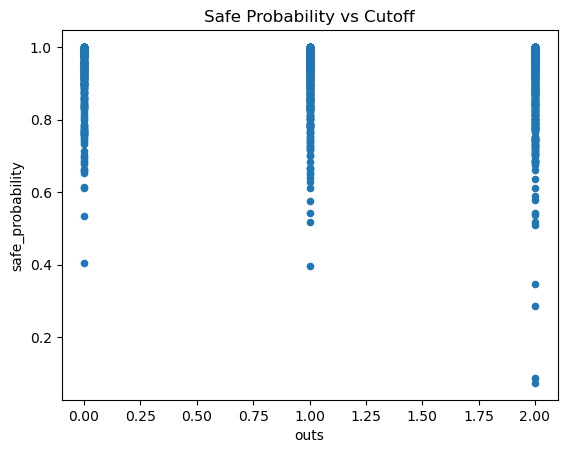

In [49]:
final_probs_outs.plot(x='outs', y='safe_probability', kind='scatter', title='Safe Probability vs Cutoff')


### Here, we can see safe probabilities dip slightly with two outs, most likely due to an increased aggressive behavior on the basepaths.

### For each cutoff play, we'll determine the optimal cutoff action through run values.

In [50]:
import itertools


# RE24 with 0 outs
re_0_out = {
    '000': 0.503, '100': 0.842, '010': 1.089, '001': 1.288, '110': 1.365, '101': 1.645, '011': 1.809, '111': 2.305
}

# RE24 with 1 out
re_1_out = {'000': 0.236, '100': 0.404, '010': 0.564, '001': 0.873, '110': 0.860, '101': 1.119, '011': 1.253, '111': 1.543
}

# RE24 with 2 outs
re_2_out = {'000': 0.087, '100': 0.165, '010': 0.273, '001': 0.316, '110': 0.394, '101': 0.482, '011': 0.539, '111': 0.759
}

# Base index dictionary
base_index = {'1B': 0, '2B': 1, '3B': 2}


# ----- Function to determine the expected run value from each change base-out permutation outcome ---- #

def compute_ev_from_paths(attempts_dict, starting_outs):
    """
    Compute expected value (EV) of a given baserunning scenario by simulating all combinations 
    of runner advancements and outcomes, and calculating the resulting
    expected runs using run expectancy dictionaries.

    Parameters:
    - attempts_dict: dictionary where keys are basepath strings and values are success probabilities.
    - starting_outs: int, number of outs at the start of the play (0, 1, or 2).

    Returns:
    - total_ev: The expected number of runs.
    """

    # Begin with initialized counter at 0
    total_ev = 0
    
    #Convert dictionary to a list
    advancements = list(attempts_dict.keys())

    # Iterate over success and failure possibilities for each advancement
    for outcome in itertools.product([0, 1], repeat=len(advancements)):
        
        # Initialize probability to be 1.0
        outcome_prob = 1
        
        #Initialize base state to be empty
        base_state = ['0', '0', '0']
        
        #Initialize runs scored to be 0
        runs_scored = 0
        
        #Initialize number of outs depending on parameter given
        num_outs = starting_outs

        #Loop through each advancement attempt and it's outcome
        for i, adv in enumerate(advancements):
            
            # Retrieve probability of success
            p_success = attempts_dict[adv]
            success = outcome[i]
            
            # Update the outcome probability based on success/failure
            outcome_prob *= p_success if success else (1 - p_success)

            from_base, to_base = adv.split("->") # e.g. "1B->3B"

            if success:
                if to_base == "Home":
                    runs_scored += 1 #Scored a run
                else:
                    base_state[base_index[to_base]] = '1' #Mark the target base as occupied by the runner
            else:
                num_outs += 1  # add an out if the runner fails

        # ----- Determine EV by base state ----- #
        
        base_str = ''.join(base_state)
        
        if num_outs >= 3:
            RE = 0 # Inning is over!
        elif num_outs == 2:
            RE = re_2_out.get(base_str, 0)
        elif num_outs == 1:
            RE = re_1_out.get(base_str, 0)
        else:  # 0 outs
            RE = re_0_out.get(base_str, 0)

        total_ev += outcome_prob * (RE + runs_scored)

    return total_ev

# ----- Example play ----- #
example_attempts = {
    "1B->3B": 0.65,
    "2B->Home": 0.85
}

ev = compute_ev_from_paths(example_attempts, 0)
print("Expected runs for example play:\n")

print(round(ev, 2))

Expected runs for example play:

1.72


In [51]:
def simulate_all_actions(group, starting_outs):

    # ------ make a dictionary like {"1B->3B": 0.7} ----- #
    attempts_dict = {
        f"{row['from_base']}->{row['to_base']}": row['safe_probability']
        for _, row in group.iterrows()
    }

    # ----- Split attempts into home plate attempts and non home-plate attempts ----- #
    home_attempts = {k: v for k, v in attempts_dict.items() if k.endswith("->Home")}
    non_home_attempts = {k: v for k, v in attempts_dict.items() if not k.endswith("->Home")}

    evs = {}

    #  letting the ball through - assume all non-home runners are safe, home runner probabilistic
    if home_attempts:
        # If there are home runners: treat home probabilistically, others safe
        let_attempts = {k: 1.0 for k in non_home_attempts}
        let_attempts.update(home_attempts)  # keep actual probabilities for home attempts
    else:
        # If no home runners: treat third base probabilistically, others safe
        let_attempts = {}
        for k, v in non_home_attempts.items():
            if k.endswith("->3B"):
                let_attempts[k] = v  # third base runner treated probabilistically
            else:
                let_attempts[k] = 1.0  # all other runners safe

    evs['let'] = compute_ev_from_paths(let_attempts, starting_outs)
    # cut and hold - assume everyone safe at targeted base (no throws), basically error prevention
    cut_hold_attempts = {k: 1.0 for k in attempts_dict}
    evs['cut_hold'] = compute_ev_from_paths(cut_hold_attempts, starting_outs)

    # cut and relay - assume home runner is safe, others probabilistic
    cut_relay_attempts = {}
    for k in attempts_dict:
        if k.endswith("->Home"):
            cut_relay_attempts[k] = 1.0 
        else:
            cut_relay_attempts[k] = attempts_dict[k] 
    evs['cut_relay'] = compute_ev_from_paths(cut_relay_attempts, starting_outs)

    return evs

### Using a buffer (0.045) between the expected run values of letting the throw through and cutting to throw to another base, will allow for cut & hold to be a valid third option in our model.

### Our decision making process is outlined in greater detail in our paper!

In [52]:
grouped = final_probs_outs.groupby(['game_str', 'play_id'])

results = []

# ---- For each game_str and play_id combination, calculate the optial action using the buffer ----- #
for (game_str, play_id), group in grouped:

    starting_outs = group['outs'].iloc[0]

    evs = simulate_all_actions(group, starting_outs)
    evs['game_str'] = game_str
    evs['play_id'] = play_id

    ev_values = [evs['let'], evs['cut_hold'], evs['cut_relay']]
    if max(ev_values) - min(ev_values) < 0.045:
        evs['optimal_action'] = 'cut_hold' # If the difference is less than 0.045 EV, then cut and hold
    else:
        evs['optimal_action'] = min(
            {'let': evs['let'], 'cut_hold': evs['cut_hold'], 'cut_relay': evs['cut_relay']},
            key=lambda x: evs[x]
        )

    results.append(evs)

ev_df = pd.DataFrame(results)

In [53]:
# ----- Optimal cutoff action distribution ------ #
ev_df['optimal_action'].value_counts()

optimal_action
cut_hold     410
let          235
cut_relay    163
Name: count, dtype: int64

In [54]:
# ----- Merge back into larger dataset ----- #
cutoff_decisions = final_probs_outs.merge(ev_df, on=['game_str', 'play_id'], how='left')  
cutoff_decisions_short = cutoff_decisions[['game_str', 'play_id', 'timestamp', 'position', 'from_base', 'to_base', 'was_safe', 'safe_probability', 'optimal_action']]
cutoff_decisions_short

,game_str,play_id,timestamp,position,from_base,to_base,was_safe,safe_probability,optimal_action
0,y1_d001_CGA_QEA,108,4098455,center field,Home,2B,True,0.997912,let
1,y1_d001_CGA_QEA,114,4231155,right field,Home,2B,True,0.905948,cut_hold
2,y1_d001_CGA_QEA,216,8333280,right field,Home,2B,False,0.827697,cut_relay
3,y1_d002_CGA_QEA,92,3087421,left field,Home,2B,True,0.834470,cut_relay
4,y1_d003_CGA_QEA,92,3994106,right field,Home,2B,True,0.950335,cut_hold
...,...,...,...,...,...,...,...,...,...
1748,y2_d095_QZE_RZQ,97,2945498,left field,2B,Home,True,0.799040,cut_relay
1749,y2_d095_QZE_RZQ,97,2945498,left field,2B,Home,True,0.799040,cut_relay
1750,y2_d095_QZE_RZQ,143,4421598,right field,2B,Home,True,0.848905,cut_relay
1751,y2_d095_QZE_RZQ,261,8351098,right field,2B,Home,True,0.999991,cut_hold


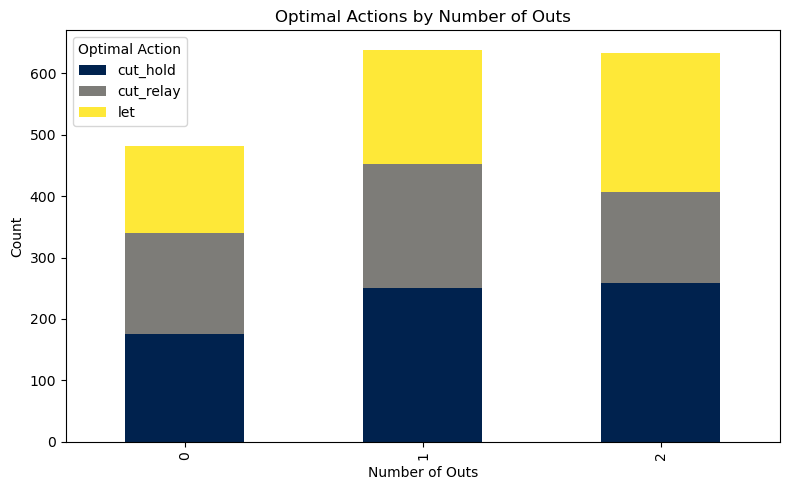

In [55]:
import matplotlib.pyplot as plt

# Count optimal actions by outs
action_counts = cutoff_decisions.groupby(['outs', 'optimal_action']).size().unstack(fill_value=0)

# Plot
action_counts.plot(kind='bar', stacked=True, figsize=(8, 5), colormap='cividis')
plt.title('Optimal Actions by Number of Outs')
plt.xlabel('Number of Outs')
plt.ylabel('Count')
plt.legend(title='Optimal Action')
plt.tight_layout()
plt.show()

### As you can see, there are more instances of extra base advancing runners with 1 or 2 outs. As it's difficult to get a runner into a position as such, it checks out that outs would have to be sacrificed. Additionally, the percentage of "let" being the optimal cutoff action is higher with 2 outs, most likely due to the aggressive nature of two outs on the basepath resulting in lower safe probability, and therefore, lower expected runs.

# Step 4: Calculate More Features for Cutoff Decision Model (Main Model)

### To eliminate overfitting, we left runner speed out of the submodel and are included only in the main model.

### Calculating Runner Speed

In [56]:
runners_df = player_pos_df[player_pos_df['player_position'].isin([11,12,13])]

runners_df

,game_str,play_id,timestamp,player_position,field_x,field_y
4471,y1_d069_ACN_QEA,7,156603,11,56.4582,70.7073
4484,y1_d069_ACN_QEA,7,156653,11,56.4012,70.8111
4497,y1_d069_ACN_QEA,7,156703,11,56.3442,70.9146
4510,y1_d069_ACN_QEA,7,156753,11,56.2875,71.0181
4523,y1_d069_ACN_QEA,7,156803,11,56.2308,71.1216
...,...,...,...,...,...,...
76350324,y1_d058_WZR_YJD,330,12032975,12,-0.5472,-1.1253
76350325,y1_d058_WZR_YJD,330,12032975,13,14.2191,-7.3068
76350336,y1_d058_WZR_YJD,330,12033008,11,-0.2910,120.6429
76350337,y1_d058_WZR_YJD,330,12033008,12,0.1224,-1.6680


In [57]:
# ----- Calculating total unique game/play/position combinations ----- #

#pull out just the three columns 
triplets = runners_df[["game_str", "play_id", "player_position"]]

#drop duplicate rows
unique_triplets = triplets.drop_duplicates()

#count them
num_unique = unique_triplets.shape[0]

print("Unique game/play/position combinations:\n\n", num_unique)

Unique game/play/position combinations:

 49667


### We'll calculate the max speed of each run by looping through their running path and finding the fastest 1-second time interval.

In [58]:
#Sort once so each group is ordered by time
runners_df = runners_df.sort_values(
    ["game_str", "play_id", "player_position", "timestamp"],
    ignore_index=True
)

threshold = 1000  # milliseconds

results = []
group_cols = ["game_str", "play_id", "player_position"]

#For each runner in the play, scan for 1+ second intervals
for (game, play, slot), gdf in runners_df.groupby(group_cols, sort=False):
    gdf = gdf.reset_index(drop=True)
    ts = gdf["timestamp"].to_numpy()
    x  = gdf["field_x"].to_numpy()
    y  = gdf["field_y"].to_numpy()
    
    # for each i, find the earliest j with ts[j] >= ts[i] + threshold
    j_idxs = np.searchsorted(ts, ts + threshold, side="left")
    
    # keep only valid pairs
    valid = j_idxs < len(ts)
    i_idxs = np.nonzero(valid)[0]
    k_idxs = j_idxs[valid]
    
    if len(i_idxs) == 0:
        continue
    
    dt = ts[k_idxs] - ts[i_idxs]  # milliseconds
    dx = x[k_idxs]  - x[i_idxs]
    dy = y[k_idxs]  - y[i_idxs]
    
    # speed in ft/s, resembling Baseball Savant!
    speeds = np.sqrt(dx*dx + dy*dy) / (dt / 1000)
    
    results.append({
        "game_str":          game,
        "play_id":           play,
        "player_position":   slot,
        "max_speed_ft_per_s": speeds.max()
    })

# ----- Build the result DataFrame and sort descending ----- #
max_speeds = (
    pd.DataFrame(results)
      .sort_values("max_speed_ft_per_s", ascending=False)
      .reset_index(drop=True)
)

max_speeds

,game_str,play_id,player_position,max_speed_ft_per_s
0,y1_d067_IAQ_YJD,70,11,31.181173
1,y2_d071_XFE_RZQ,197,11,31.002160
2,y1_d091_DYE_RZQ,239,11,30.909686
3,y2_d043_RZQ_YJD,125,11,30.877511
4,y1_d064_UEX_RZQ,118,11,30.814254
...,...,...,...,...
35320,y2_d032_KNB_YJD,236,11,0.000000
35321,y2_d007_DYE_RZQ,104,11,0.000000
35322,y1_d011_DYE_RZQ,281,12,0.000000
35323,y1_d023_AKX_YJD,176,11,0.000000


In [59]:
# ----- Starting from big_ie DataFrame ----- #

# We only need one row per play to get the runner IDs:
runners = (
    big_ie
    # select the columns we care about
    [["game_str","play_id","first_baserunner","second_baserunner","third_baserunner"]]
    # drop duplicate rows so there’s one line per play
    .drop_duplicates(subset=["game_str","play_id"])
    # melt wide→long so we get one row per runner slot
    .melt(
        id_vars=["game_str","play_id"],
        value_vars=["first_baserunner","second_baserunner","third_baserunner"],
        var_name="slot_name",
        value_name="player_id"
    )
    # map slot_name to the numeric player_position
    .assign(
        player_position = lambda d: d["slot_name"].map({
            "first_baserunner":  11,
            "second_baserunner": 12,
            "third_baserunner":  13
        })
    )
    # drop any missing (e.g. innings with no runner on 3rd)
    .dropna(subset=["player_id"])
    .drop(columns="slot_name")
)

# ----- Merge with max_speeds dataframe ----- #
# (which has columns game_str, play_id, player_position, max_speed_ft_per_s)

runnerwspeeds = (
    max_speeds
    .merge(
        runners,
        on=["game_str","play_id","player_position"],
        how="left"
    )
)

runnerwspeeds = runnerwspeeds[runnerwspeeds["max_speed_ft_per_s"] >= 10]

runnerwspeeds

,game_str,play_id,player_position,max_speed_ft_per_s,player_id
0,y1_d067_IAQ_YJD,70,11,31.181173,IAQ-1783
1,y2_d071_XFE_RZQ,197,11,31.002160,XFE-2484
2,y1_d091_DYE_RZQ,239,11,30.909686,NA
3,y2_d043_RZQ_YJD,125,11,30.877511,RZQ-0385
4,y1_d064_UEX_RZQ,118,11,30.814254,UEX-1111
...,...,...,...,...,...
9370,y2_d044_RZQ_YJD,238,11,10.020939,YJD-0373
9371,y2_d025_ALA_YJD,200,11,10.015362,YJD-0080
9372,y2_d084_LFS_YJD,298,11,10.014888,YJD-0429
9373,y2_d006_NSO_YJD,204,11,10.012432,NaN


In [60]:
# ----- Group by individual runner_id and calculate stats ----- #

player_stats = (
    runnerwspeeds
    .groupby("player_id", dropna=True)
    .agg(
        num_appearances=("player_id", "size"),
        peak_speed_ft_per_s=("max_speed_ft_per_s", "max"),
        pct90_speed_ft_per_s=("max_speed_ft_per_s", lambda x: x.quantile(0.9))
    )
    .reset_index()
    .query("num_appearances >= 5") # keep only players with at least 5 appearances
    .sort_values("pct90_speed_ft_per_s", ascending=False) # sort by 90th percentile speed, highest first
    .reset_index(drop=True)
)

player_stats

,player_id,num_appearances,peak_speed_ft_per_s,pct90_speed_ft_per_s
0,IAQ-1783,12,31.181173,30.444060
1,IKJ-2180,9,29.627385,29.361257
2,RZQ-0385,18,30.877511,29.338936
3,XFE-2484,7,31.002160,29.190104
4,ALA-2442,5,29.474691,29.181994
...,...,...,...,...
346,YJD-0016,5,23.657485,21.925403
347,RQJ-1518,5,22.121443,21.876424
348,GHD-1074,7,23.702032,21.839530
349,NYA-2152,5,21.437443,21.313309


### Additionally, we'll calculate the distance from the cutoff man to the baserunner's targeted base.  We need to analyze observed cutoffs, in order to do so.

### Going back to our ball_acquired_df dataframe...

In [61]:
combos = ball_acquired_of[['game_str', 'play_id']].drop_duplicates()
combos

,game_str,play_id
0,y1_d001_CGA_QEA,108
1,y1_d001_CGA_QEA,114
2,y1_d001_CGA_QEA,216
3,y1_d002_CGA_QEA,92
4,y1_d002_CGA_QEA,99
...,...,...
951,y2_d097_YJD_RZQ,19
952,y2_d097_YJD_RZQ,53
953,y2_d097_YJD_RZQ,135
954,y2_d097_YJD_RZQ,158


In [62]:
# ----- Inferring the defensive cutoff decision using event sequencing from prior, filtered datasets ------ #

# Initialize a list to store results
cutoff_results = []


# Iterate through each row of the combos dataframe
for _, row in combos.iterrows():
    game_str = row['game_str']
    play_id = row['play_id']
    
    # Extract the subset of events for this specific play, chronologically
    play_events = big_ie[(big_ie['game_str'] == game_str) & (big_ie['play_id'] == play_id)]
    play_events = play_events.sort_values('timestamp')

    # Find all outfielder ball acquired events
    of_acq = play_events[
        (play_events['play_type'] == 'ball acquired') &
        (play_events['position'].isin(['left field', 'center field', 'right field']))
    ]
    
    # If there was no outfielder who acquired the ball, record null values and skip the play
    if of_acq.empty:
        cutoff_results.append({'game_str': game_str, 'play_id': play_id, 'cutoff_man': None, 'cutoff_decision': None})
        continue

    # Find the first outfielder to acquire the ball
    first_of_acq_idx = of_acq.index[0]

    # Find the next ball acquired event after the outfielder
    after_of = play_events.loc[first_of_acq_idx+1:]

    # Search for the next "ball acquired" play type after the outfielder's ball acquired event
    cutoff_acq = after_of[(after_of['play_type'] == 'ball acquired') & (~after_of['position'].isin(['left field', 'center field', 'right field']))]
    
    # If no cutoff man found, fill None and skip
    if cutoff_acq.empty:
        cutoff_results.append({'game_str': game_str, 'play_id': play_id, 'cutoff_man': None, 'cutoff_decision': None})
        continue

    # Identify the cutoff man by position and index
    cutoff_row = cutoff_acq.iloc[0]
    cutoff_man = cutoff_row['position']
    cutoff_idx = cutoff_row.name

    # Find if cutoff man threw the ball (event_code == 3) after acquiring
    # Makes sure that this player is actually a cutoff man
    after_cutoff = play_events.loc[cutoff_idx+1:]
    throws = after_cutoff[(after_cutoff['event_code'] == 2)]
    
    # ----- Decision Logic ----- #
    # If the cutoff man is the catcher, mark this cutoff play as "let" because no one cut the outfield throw off
    if cutoff_man == 'catcher':
        cutoff_decision = 'let'
        
    # If no throw was made after the cutoff man caught the ball, mark this cutoff play as "cut and hold"
    elif throws.empty:
        cutoff_decision = 'cut_hold'
        
    else:
        # Check which position received the throw from the cutoff man
        throw_row = throws.iloc[0]
        receiver_pos = throw_row['position']
        
        # If it was the catcher that received the throw, still categorize that play as "let"
        if receiver_pos == 'catcher':
            cutoff_decision = 'let'
        
        # If it wasn't the catcher, the cutoff man cut and threw to another base, so mark this play as a "cut and relay"
        else:
            cutoff_decision = 'cut_relay'


    # Append all the cutoff decision data together in the list
    cutoff_results.append({'game_str': game_str, 'play_id': play_id, 'cutoff_man': cutoff_man, 'cutoff_decision': cutoff_decision})

# Convert into dataframe
cutoff_df = pd.DataFrame(cutoff_results)
cutoff_df

,game_str,play_id,cutoff_man,cutoff_decision
0,y1_d001_CGA_QEA,108,second baseman,cut_relay
1,y1_d001_CGA_QEA,114,second baseman,cut_hold
2,y1_d001_CGA_QEA,216,shortstop,cut_hold
3,y1_d002_CGA_QEA,92,shortstop,cut_relay
4,y1_d002_CGA_QEA,99,third baseman,cut_hold
...,...,...,...,...
874,y2_d097_YJD_RZQ,19,second baseman,cut_hold
875,y2_d097_YJD_RZQ,53,shortstop,let
876,y2_d097_YJD_RZQ,135,first baseman,cut_hold
877,y2_d097_YJD_RZQ,158,shortstop,let


In [63]:
# ----- Get rid of rows with N/A cutoff decision ----- #

cuts = cutoff_df[cutoff_df['cutoff_decision'].notna()]
cuts

,game_str,play_id,cutoff_man,cutoff_decision
0,y1_d001_CGA_QEA,108,second baseman,cut_relay
1,y1_d001_CGA_QEA,114,second baseman,cut_hold
2,y1_d001_CGA_QEA,216,shortstop,cut_hold
3,y1_d002_CGA_QEA,92,shortstop,cut_relay
4,y1_d002_CGA_QEA,99,third baseman,cut_hold
...,...,...,...,...
874,y2_d097_YJD_RZQ,19,second baseman,cut_hold
875,y2_d097_YJD_RZQ,53,shortstop,let
876,y2_d097_YJD_RZQ,135,first baseman,cut_hold
877,y2_d097_YJD_RZQ,158,shortstop,let


In [64]:
# ----- Merge cutoff decision making into larger cutoff decision dataframe ----- #

with_obs = cutoff_decisions.merge(cuts, on=['game_str', 'play_id'], how='left')
with_obs

,game_str,play_id,timestamp,player_position,position,play_type,home_team,away_team,top_bottom_inning,fielding_team,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,field_x_7,field_y_7,field_x_8,field_y_8,field_x_9,field_y_9,field_x_10,field_y_10,field_x_11,field_y_11,field_x_12,field_y_12,ball_position_x,ball_position_y,ball_position_z,arm_strength_mph,as+,runner_id,from_base,to_base,attempted,was_safe,runner_x,runner_y,runner_dist_to_base,fielder_x,fielder_y,fielder_dist_to_base,safe_probability,outs,let,cut_hold,cut_relay,optimal_action,cutoff_man,cutoff_decision
0,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,-110.8791,230.5518,94.4808,338.4810,65.4084,291.4254,35.7615,110.5899,-44.5356,100.8936,-62.0019,65.0769,95.3448,339.4440,0.000000,58.470382,115.5,10,Home,2B,True,True,35.7615,110.5899,39.346871,94.4808,338.4810,231.626499,0.997912,1,3.030436,3.253,3.095591,let,second baseman,cut_relay
1,y1_d001_CGA_QEA,114,4231155,9,right field,ball acquired,QEA,CGA,top,QEA,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1353,CGA-1824,CGA-1929,CGA-1592,-121.0008,236.3949,28.4658,327.7230,139.5966,299.0814,61.1802,61.2882,NaN,NaN,NaN,NaN,138.1734,295.9152,5.194530,56.607167,109.8,10,Home,2B,True,True,61.1802,61.2882,89.783392,139.5966,299.0814,221.583436,0.905948,1,0.564000,0.564,0.519137,cut_hold,second baseman,cut_hold
2,y1_d001_CGA_QEA,216,8333280,9,right field,ball acquired,QEA,CGA,top,QEA,QEA-0152,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1929,CGA-1592,CGA-1547,NA,-119.2062,233.3106,-29.9289,274.1229,188.1207,245.4093,56.9868,46.3326,NaN,NaN,-50.5641,38.5989,188.0088,246.3627,0.000000,67.167101,109.8,10,Home,2B,True,False,56.9868,46.3326,98.766010,188.1207,245.4093,222.283963,0.827697,1,1.563679,1.564,1.481811,cut_relay,shortstop,cut_hold
3,y1_d002_CGA_QEA,92,3087421,7,left field,ball acquired,QEA,CGA,bottom,CGA,CGA-2074,CGA-1127,CGA-1592,CGA-1824,CGA-1198,CGA-2010,CGA-1353,CGA-1458,CGA-1547,QEA-0252,QEA-0235,QEA-0120,NA,-200.5506,236.1000,-61.6011,276.9882,113.8962,207.5649,57.1884,47.2554,-6.3957,122.2593,-57.1140,67.5888,-201.4455,237.1629,0.000000,62.909130,94.7,10,Home,2B,True,True,57.1884,47.2554,98.131108,-200.5506,236.1000,228.305395,0.834470,0,2.797617,2.809,2.526508,cut_relay,shortstop,cut_relay
4,y1_d003_CGA_QEA,92,3994106,9,right field,ball acquired,QEA,CGA,bottom,CGA,CGA-1302,CGA-1503,CGA-1592,CGA-1458,CGA-1166,CGA-2010,CGA-1824,CGA-1547,CGA-1198,QEA-0249,QEA-0365,NA,NA,-136.9167,241.8789,51.5217,335.9463,69.6903,327.1002,59.4930,72.1209,NaN,NaN,NaN,NaN,67.7784,325.8180,0.011808,65.544151,106.3,10,Home,2B,True,True,59.4930,72.1209,80.939068,69.6903,327.1002,211.888716,0.950335,2,0.273000,0.273,0.259442,cut_hold,second baseman,cut_hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1748,y2_d095_QZE_RZQ,97,2945498,7,left field,ball acquired,RZQ,QZE,bottom,QZE,QZE-2482,QZE-2394,QZE-1252,QZE-1479,QZE-2357,QZE-1888,QZE-2217,QZE-1638,QZE-2280,RZQ-0414,RZQ-0040,RZQ-0409,NA,-100.2816,242.7507,-29.2206,301.5186,117.9345,262.6098,23.4867,17.3817,10.9254,123.0792,-60.0858,78.1305,-100.0560,246.7371,1.275069,69.591611,118.6,12,2B,Home,True,True,-60.0858,78.1305,98.563068,-100.2816,242.7507,262.648628,0.799040,1,1.560106,1.873,1.512933,cut_relay,pitcher,cut_relay
1749,y2_d095_QZE_RZQ,97,2945498,7,left field,ball acquired,RZQ,QZE,bottom,QZE,QZE-2482,QZE-2394,QZE-1252,QZE-1479,QZE-2357,QZE-1888,QZE-2217,QZE-1638,QZE-2280,RZQ-0414,RZQ-0040,RZQ-0409,NA,-100.2816,242.7507,-29.2206,301.5186,117.9345,262.6098,23.4867,17.3817,10.9254,

In [65]:
# ----- Redefine position keys to identify cutoff man positions ----- #

position_key = pd.DataFrame({
    "cut_code": [*range(1, 14), 255, 14, 15, 16, 17, 18, 19],
    "cut_position": [
        "pitcher", "catcher", "first baseman", "second baseman", "third baseman",
        "shortstop", "left field", "center field", "right field", "batter",
        "runner on first base", "runner on second base", "runner on third base",
        "ball event with no player (e.g., ball bounce)", "home plate umpire",
        "field umpire", "field umpire", "field umpire",
        "first base coach", "third base coach"
    ]
}) 

# Merge position key dictionary onto earlier player position dataframe to retrieve cutoff man positions
player_pos = player_pos_df.merge(
    position_key, left_on='player_position', right_on='cut_code', how='left').drop(
    columns=['player_position'])

player_pos

,game_str,play_id,timestamp,field_x,field_y,cut_code,cut_position
0,y1_d069_ACN_QEA,1,14853,0.6102,58.6314,1,pitcher
1,y1_d069_ACN_QEA,1,14853,1.7643,-6.4374,2,catcher
2,y1_d069_ACN_QEA,1,14853,69.9423,98.1246,3,first baseman
3,y1_d069_ACN_QEA,1,14853,37.2924,146.9091,4,second baseman
4,y1_d069_ACN_QEA,1,14853,-66.9441,86.1147,5,third baseman
...,...,...,...,...,...,...,...
76350334,y1_d058_WZR_YJD,330,12033008,94.1688,194.3637,9,right field
76350335,y1_d058_WZR_YJD,330,12033008,46.8339,87.3768,10,batter
76350336,y1_d058_WZR_YJD,330,12033008,-0.2910,120.6429,11,runner on first base
76350337,y1_d058_WZR_YJD,330,12033008,0.1224,-1.6680,12,runner on second base


In [66]:
# ----- Continue to merge back into previous, larger dataset ----- #

# Merging cutoff man position identification dataset with larger cutoff decision dataset
everything_df = with_obs.merge(
    player_pos,
    left_on=['game_str', 'play_id', 'timestamp', 'cutoff_man'],
    right_on=['game_str', 'play_id', 'timestamp', 'cut_position'],
    how='left'
).rename(
    columns={
        'field_x': 'cutoff_x', 
        'field_y': 'cutoff_y'
    }
).drop(columns=['cut_position'])

everything_df

,game_str,play_id,timestamp,player_position,position,play_type,home_team,away_team,top_bottom_inning,fielding_team,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,field_x_7,field_y_7,field_x_8,field_y_8,field_x_9,field_y_9,field_x_10,field_y_10,field_x_11,field_y_11,field_x_12,field_y_12,ball_position_x,ball_position_y,ball_position_z,arm_strength_mph,as+,runner_id,from_base,to_base,attempted,was_safe,runner_x,runner_y,runner_dist_to_base,fielder_x,fielder_y,fielder_dist_to_base,safe_probability,outs,let,cut_hold,cut_relay,optimal_action,cutoff_man,cutoff_decision,cutoff_x,cutoff_y,cut_code
0,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,-110.8791,230.5518,94.4808,338.4810,65.4084,291.4254,35.7615,110.5899,-44.5356,100.8936,-62.0019,65.0769,95.3448,339.4440,0.000000,58.470382,115.5,10,Home,2B,True,True,35.7615,110.5899,39.346871,94.4808,338.4810,231.626499,0.997912,1,3.030436,3.253,3.095591,let,second baseman,cut_relay,41.7405,194.3859,4.0
1,y1_d001_CGA_QEA,114,4231155,9,right field,ball acquired,QEA,CGA,top,QEA,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1353,CGA-1824,CGA-1929,CGA-1592,-121.0008,236.3949,28.4658,327.7230,139.5966,299.0814,61.1802,61.2882,NaN,NaN,NaN,NaN,138.1734,295.9152,5.194530,56.607167,109.8,10,Home,2B,True,True,61.1802,61.2882,89.783392,139.5966,299.0814,221.583436,0.905948,1,0.564000,0.564,0.519137,cut_hold,second baseman,cut_hold,25.8921,137.6235,4.0
2,y1_d001_CGA_QEA,216,8333280,9,right field,ball acquired,QEA,CGA,top,QEA,QEA-0152,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1929,CGA-1592,CGA-1547,NA,-119.2062,233.3106,-29.9289,274.1229,188.1207,245.4093,56.9868,46.3326,NaN,NaN,-50.5641,38.5989,188.0088,246.3627,0.000000,67.167101,109.8,10,Home,2B,True,False,56.9868,46.3326,98.766010,188.1207,245.4093,222.283963,0.827697,1,1.563679,1.564,1.481811,cut_relay,shortstop,cut_hold,11.6007,132.4140,6.0
3,y1_d002_CGA_QEA,92,3087421,7,left field,ball acquired,QEA,CGA,bottom,CGA,CGA-2074,CGA-1127,CGA-1592,CGA-1824,CGA-1198,CGA-2010,CGA-1353,CGA-1458,CGA-1547,QEA-0252,QEA-0235,QEA-0120,NA,-200.5506,236.1000,-61.6011,276.9882,113.8962,207.5649,57.1884,47.2554,-6.3957,122.2593,-57.1140,67.5888,-201.4455,237.1629,0.000000,62.909130,94.7,10,Home,2B,True,True,57.1884,47.2554,98.131108,-200.5506,236.1000,228.305395,0.834470,0,2.797617,2.809,2.526508,cut_relay,shortstop,cut_relay,-55.6794,140.5182,6.0
4,y1_d003_CGA_QEA,92,3994106,9,right field,ball acquired,QEA,CGA,bottom,CGA,CGA-1302,CGA-1503,CGA-1592,CGA-1458,CGA-1166,CGA-2010,CGA-1824,CGA-1547,CGA-1198,QEA-0249,QEA-0365,NA,NA,-136.9167,241.8789,51.5217,335.9463,69.6903,327.1002,59.4930,72.1209,NaN,NaN,NaN,NaN,67.7784,325.8180,0.011808,65.544151,106.3,10,Home,2B,True,True,59.4930,72.1209,80.939068,69.6903,327.1002,211.888716,0.950335,2,0.273000,0.273,0.259442,cut_hold,second baseman,cut_hold,18.4110,161.4603,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1748,y2_d095_QZE_RZQ,97,2945498,7,left field,ball acquired,RZQ,QZE,bottom,QZE,QZE-2482,QZE-2394,QZE-1252,QZE-1479,QZE-2357,QZE-1888,QZE-2217,QZE-1638,QZE-2280,RZQ-0414,RZQ-0040,RZQ-0409,NA,-100.2816,242.7507,-29.2206,301.5186,117.9345,262.6098,23.4867,17.3817,10.9254,123.0792,-60.0858,78.1305,-100.0560,246.7371,1.275069,69.591611,118.6,12,2B,Home,True,True,-60.0858,78.1305,98.563068,-100.2816,242.7507,262.648628,0.799040,1,1.560106,1.873,1.512933,cut_relay,pitcher,cut_relay,-5.2521,51.3606,1.0
1749,y2_d095_QZE_RZQ,97,2945498,7,left field,ball acquired,RZQ,QZE,bottom,QZE,QZE-2482,QZE-2394,QZE-125

In [67]:
# ----- More data cleaning against null values ----- #

everything_df = everything_df[everything_df['cutoff_man'].notna()]
everything_df

,game_str,play_id,timestamp,player_position,position,play_type,home_team,away_team,top_bottom_inning,fielding_team,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,field_x_7,field_y_7,field_x_8,field_y_8,field_x_9,field_y_9,field_x_10,field_y_10,field_x_11,field_y_11,field_x_12,field_y_12,ball_position_x,ball_position_y,ball_position_z,arm_strength_mph,as+,runner_id,from_base,to_base,attempted,was_safe,runner_x,runner_y,runner_dist_to_base,fielder_x,fielder_y,fielder_dist_to_base,safe_probability,outs,let,cut_hold,cut_relay,optimal_action,cutoff_man,cutoff_decision,cutoff_x,cutoff_y,cut_code
0,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,-110.8791,230.5518,94.4808,338.4810,65.4084,291.4254,35.7615,110.5899,-44.5356,100.8936,-62.0019,65.0769,95.3448,339.4440,0.000000,58.470382,115.5,10,Home,2B,True,True,35.7615,110.5899,39.346871,94.4808,338.4810,231.626499,0.997912,1,3.030436,3.253,3.095591,let,second baseman,cut_relay,41.7405,194.3859,4.0
1,y1_d001_CGA_QEA,114,4231155,9,right field,ball acquired,QEA,CGA,top,QEA,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1353,CGA-1824,CGA-1929,CGA-1592,-121.0008,236.3949,28.4658,327.7230,139.5966,299.0814,61.1802,61.2882,NaN,NaN,NaN,NaN,138.1734,295.9152,5.194530,56.607167,109.8,10,Home,2B,True,True,61.1802,61.2882,89.783392,139.5966,299.0814,221.583436,0.905948,1,0.564000,0.564,0.519137,cut_hold,second baseman,cut_hold,25.8921,137.6235,4.0
2,y1_d001_CGA_QEA,216,8333280,9,right field,ball acquired,QEA,CGA,top,QEA,QEA-0152,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1929,CGA-1592,CGA-1547,NA,-119.2062,233.3106,-29.9289,274.1229,188.1207,245.4093,56.9868,46.3326,NaN,NaN,-50.5641,38.5989,188.0088,246.3627,0.000000,67.167101,109.8,10,Home,2B,True,False,56.9868,46.3326,98.766010,188.1207,245.4093,222.283963,0.827697,1,1.563679,1.564,1.481811,cut_relay,shortstop,cut_hold,11.6007,132.4140,6.0
3,y1_d002_CGA_QEA,92,3087421,7,left field,ball acquired,QEA,CGA,bottom,CGA,CGA-2074,CGA-1127,CGA-1592,CGA-1824,CGA-1198,CGA-2010,CGA-1353,CGA-1458,CGA-1547,QEA-0252,QEA-0235,QEA-0120,NA,-200.5506,236.1000,-61.6011,276.9882,113.8962,207.5649,57.1884,47.2554,-6.3957,122.2593,-57.1140,67.5888,-201.4455,237.1629,0.000000,62.909130,94.7,10,Home,2B,True,True,57.1884,47.2554,98.131108,-200.5506,236.1000,228.305395,0.834470,0,2.797617,2.809,2.526508,cut_relay,shortstop,cut_relay,-55.6794,140.5182,6.0
4,y1_d003_CGA_QEA,92,3994106,9,right field,ball acquired,QEA,CGA,bottom,CGA,CGA-1302,CGA-1503,CGA-1592,CGA-1458,CGA-1166,CGA-2010,CGA-1824,CGA-1547,CGA-1198,QEA-0249,QEA-0365,NA,NA,-136.9167,241.8789,51.5217,335.9463,69.6903,327.1002,59.4930,72.1209,NaN,NaN,NaN,NaN,67.7784,325.8180,0.011808,65.544151,106.3,10,Home,2B,True,True,59.4930,72.1209,80.939068,69.6903,327.1002,211.888716,0.950335,2,0.273000,0.273,0.259442,cut_hold,second baseman,cut_hold,18.4110,161.4603,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747,y2_d094_QZE_RZQ,344,11857564,9,right field,ball acquired,RZQ,QZE,bottom,QZE,QZE-2449,QZE-2394,QZE-1252,QZE-1479,QZE-2357,QZE-1245,QZE-2280,QZE-1638,QZE-2217,RZQ-0414,RZQ-0347,RZQ-0310,NA,-106.7781,143.1831,66.1776,264.8085,233.5866,234.6720,20.2089,125.0232,-60.2076,60.5493,-13.8180,9.9936,233.1327,228.2667,-1.903200,69.072985,100.8,12,2B,Home,True,True,-13.8180,9.9936,17.053128,233.5866,234.6720,331.109721,1.000000,2,2.512677,2.539,2.438214,cut_relay,shortstop,cut_hold,2.4942,88.6911,6.0
1748,y2_d095_QZE_RZQ,97,2945498,7,left field,ball acquired,RZQ,QZE,bottom,QZE,QZE-2482,QZE-2394,QZE-125

In [68]:
# ----- Using base coordinates defined previously, define a function to calculate the distance from the cutoff man to the targeted base ----- #

def compute_cutoff_distance(row):
    bx, by = base_coords.get(row['to_base'], (np.nan, np.nan))
    return np.sqrt((row['cutoff_x'] - bx)**2 + (row['cutoff_y'] - by)**2)

everything_df['cutoff_dist_to_base'] = everything_df.apply(compute_cutoff_distance, axis=1)
everything_df

,game_str,play_id,timestamp,player_position,position,play_type,home_team,away_team,top_bottom_inning,fielding_team,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,field_x_7,field_y_7,field_x_8,field_y_8,field_x_9,field_y_9,field_x_10,field_y_10,field_x_11,field_y_11,field_x_12,field_y_12,ball_position_x,ball_position_y,ball_position_z,arm_strength_mph,as+,runner_id,from_base,to_base,attempted,was_safe,runner_x,runner_y,runner_dist_to_base,fielder_x,fielder_y,fielder_dist_to_base,safe_probability,outs,let,cut_hold,cut_relay,optimal_action,cutoff_man,cutoff_decision,cutoff_x,cutoff_y,cut_code,cutoff_dist_to_base
0,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,-110.8791,230.5518,94.4808,338.4810,65.4084,291.4254,35.7615,110.5899,-44.5356,100.8936,-62.0019,65.0769,95.3448,339.4440,0.000000,58.470382,115.5,10,Home,2B,True,True,35.7615,110.5899,39.346871,94.4808,338.4810,231.626499,0.997912,1,3.030436,3.253,3.095591,let,second baseman,cut_relay,41.7405,194.3859,4.0,79.266190
1,y1_d001_CGA_QEA,114,4231155,9,right field,ball acquired,QEA,CGA,top,QEA,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1353,CGA-1824,CGA-1929,CGA-1592,-121.0008,236.3949,28.4658,327.7230,139.5966,299.0814,61.1802,61.2882,NaN,NaN,NaN,NaN,138.1734,295.9152,5.194530,56.607167,109.8,10,Home,2B,True,True,61.1802,61.2882,89.783392,139.5966,299.0814,221.583436,0.905948,1,0.564000,0.564,0.519137,cut_hold,second baseman,cut_hold,25.8921,137.6235,4.0,27.986775
2,y1_d001_CGA_QEA,216,8333280,9,right field,ball acquired,QEA,CGA,top,QEA,QEA-0152,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1929,CGA-1592,CGA-1547,NA,-119.2062,233.3106,-29.9289,274.1229,188.1207,245.4093,56.9868,46.3326,NaN,NaN,-50.5641,38.5989,188.0088,246.3627,0.000000,67.167101,109.8,10,Home,2B,True,False,56.9868,46.3326,98.766010,188.1207,245.4093,222.283963,0.827697,1,1.563679,1.564,1.481811,cut_relay,shortstop,cut_hold,11.6007,132.4140,6.0,12.801861
3,y1_d002_CGA_QEA,92,3087421,7,left field,ball acquired,QEA,CGA,bottom,CGA,CGA-2074,CGA-1127,CGA-1592,CGA-1824,CGA-1198,CGA-2010,CGA-1353,CGA-1458,CGA-1547,QEA-0252,QEA-0235,QEA-0120,NA,-200.5506,236.1000,-61.6011,276.9882,113.8962,207.5649,57.1884,47.2554,-6.3957,122.2593,-57.1140,67.5888,-201.4455,237.1629,0.000000,62.909130,94.7,10,Home,2B,True,True,57.1884,47.2554,98.131108,-200.5506,236.1000,228.305395,0.834470,0,2.797617,2.809,2.526508,cut_relay,shortstop,cut_relay,-55.6794,140.5182,6.0,57.296922
4,y1_d003_CGA_QEA,92,3994106,9,right field,ball acquired,QEA,CGA,bottom,CGA,CGA-1302,CGA-1503,CGA-1592,CGA-1458,CGA-1166,CGA-2010,CGA-1824,CGA-1547,CGA-1198,QEA-0249,QEA-0365,NA,NA,-136.9167,241.8789,51.5217,335.9463,69.6903,327.1002,59.4930,72.1209,NaN,NaN,NaN,NaN,67.7784,325.8180,0.011808,65.544151,106.3,10,Home,2B,True,True,59.4930,72.1209,80.939068,69.6903,327.1002,211.888716,0.950335,2,0.273000,0.273,0.259442,cut_hold,second baseman,cut_hold,18.4110,161.4603,4.0,39.070157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747,y2_d094_QZE_RZQ,344,11857564,9,right field,ball acquired,RZQ,QZE,bottom,QZE,QZE-2449,QZE-2394,QZE-1252,QZE-1479,QZE-2357,QZE-1245,QZE-2280,QZE-1638,QZE-2217,RZQ-0414,RZQ-0347,RZQ-0310,NA,-106.7781,143.1831,66.1776,264.8085,233.5866,234.6720,20.2089,125.0232,-60.2076,60.5493,-13.8180,9.9936,233.1327,228.2667,-1.903200,69.072985,100.8,12,2B,Home,True,True,-13.8180,9.9936,17.053128,233.5866,234.6720,331.109721,1.000000,2,2.512677,2.539,2.438214,cut_relay,shortstop,cut_hold,2.4942,88.6911,6.0,88.726164
1748,y2_d095_QZE_RZ

In [69]:
# ----- Identify baserunner_id's for all runners each play ----- #

def get_baserunner_id(row):
    if row['from_base'] == 'Home':
        return row['batter']
    elif row['from_base'] == '1B':
        return row['first_baserunner']
    elif row['from_base'] == '2B':
        return row['second_baserunner']
    else:
        return None

everything_df['baserunner_player_id'] = everything_df.apply(get_baserunner_id, axis=1)
everything_df

,game_str,play_id,timestamp,player_position,position,play_type,home_team,away_team,top_bottom_inning,fielding_team,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,field_x_7,field_y_7,field_x_8,field_y_8,field_x_9,field_y_9,field_x_10,field_y_10,field_x_11,field_y_11,field_x_12,field_y_12,ball_position_x,ball_position_y,ball_position_z,arm_strength_mph,as+,runner_id,from_base,to_base,attempted,was_safe,runner_x,runner_y,runner_dist_to_base,fielder_x,fielder_y,fielder_dist_to_base,safe_probability,outs,let,cut_hold,cut_relay,optimal_action,cutoff_man,cutoff_decision,cutoff_x,cutoff_y,cut_code,cutoff_dist_to_base,baserunner_player_id
0,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,-110.8791,230.5518,94.4808,338.4810,65.4084,291.4254,35.7615,110.5899,-44.5356,100.8936,-62.0019,65.0769,95.3448,339.4440,0.000000,58.470382,115.5,10,Home,2B,True,True,35.7615,110.5899,39.346871,94.4808,338.4810,231.626499,0.997912,1,3.030436,3.253,3.095591,let,second baseman,cut_relay,41.7405,194.3859,4.0,79.266190,CGA-1824
1,y1_d001_CGA_QEA,114,4231155,9,right field,ball acquired,QEA,CGA,top,QEA,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1353,CGA-1824,CGA-1929,CGA-1592,-121.0008,236.3949,28.4658,327.7230,139.5966,299.0814,61.1802,61.2882,NaN,NaN,NaN,NaN,138.1734,295.9152,5.194530,56.607167,109.8,10,Home,2B,True,True,61.1802,61.2882,89.783392,139.5966,299.0814,221.583436,0.905948,1,0.564000,0.564,0.519137,cut_hold,second baseman,cut_hold,25.8921,137.6235,4.0,27.986775,CGA-1353
2,y1_d001_CGA_QEA,216,8333280,9,right field,ball acquired,QEA,CGA,top,QEA,QEA-0152,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1929,CGA-1592,CGA-1547,NA,-119.2062,233.3106,-29.9289,274.1229,188.1207,245.4093,56.9868,46.3326,NaN,NaN,-50.5641,38.5989,188.0088,246.3627,0.000000,67.167101,109.8,10,Home,2B,True,False,56.9868,46.3326,98.766010,188.1207,245.4093,222.283963,0.827697,1,1.563679,1.564,1.481811,cut_relay,shortstop,cut_hold,11.6007,132.4140,6.0,12.801861,CGA-1929
3,y1_d002_CGA_QEA,92,3087421,7,left field,ball acquired,QEA,CGA,bottom,CGA,CGA-2074,CGA-1127,CGA-1592,CGA-1824,CGA-1198,CGA-2010,CGA-1353,CGA-1458,CGA-1547,QEA-0252,QEA-0235,QEA-0120,NA,-200.5506,236.1000,-61.6011,276.9882,113.8962,207.5649,57.1884,47.2554,-6.3957,122.2593,-57.1140,67.5888,-201.4455,237.1629,0.000000,62.909130,94.7,10,Home,2B,True,True,57.1884,47.2554,98.131108,-200.5506,236.1000,228.305395,0.834470,0,2.797617,2.809,2.526508,cut_relay,shortstop,cut_relay,-55.6794,140.5182,6.0,57.296922,QEA-0252
4,y1_d003_CGA_QEA,92,3994106,9,right field,ball acquired,QEA,CGA,bottom,CGA,CGA-1302,CGA-1503,CGA-1592,CGA-1458,CGA-1166,CGA-2010,CGA-1824,CGA-1547,CGA-1198,QEA-0249,QEA-0365,NA,NA,-136.9167,241.8789,51.5217,335.9463,69.6903,327.1002,59.4930,72.1209,NaN,NaN,NaN,NaN,67.7784,325.8180,0.011808,65.544151,106.3,10,Home,2B,True,True,59.4930,72.1209,80.939068,69.6903,327.1002,211.888716,0.950335,2,0.273000,0.273,0.259442,cut_hold,second baseman,cut_hold,18.4110,161.4603,4.0,39.070157,QEA-0249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747,y2_d094_QZE_RZQ,344,11857564,9,right field,ball acquired,RZQ,QZE,bottom,QZE,QZE-2449,QZE-2394,QZE-1252,QZE-1479,QZE-2357,QZE-1245,QZE-2280,QZE-1638,QZE-2217,RZQ-0414,RZQ-0347,RZQ-0310,NA,-106.7781,143.1831,66.1776,264.8085,233.5866,234.6720,20.2089,125.0232,-60.2076,60.5493,-13.8180,9.9936,233.1327,228.2667,-1.903200,69.072985,100.8,12,2B,Home,True,True,-13.8180,9.9936,17.053128,233.5866,234.6720,331.109721,1.000000,2,2.512677,2.539,2.438214,cut_rel

### Creating a Confusion Design Matrix to Compare Optimal, EV-Driven, Cutoff Action vs. Observed Cutoff Action

In [70]:
design_matrix = everything_df[['game_str', 'play_id', 'timestamp', 'baserunner_player_id', 'from_base', 'to_base', 'runner_x',
'runner_y', 'runner_dist_to_base', 'cutoff_x', 'cutoff_y', 'cutoff_dist_to_base', 'fielder_x', 'fielder_y',
'fielder_dist_to_base', 'as+', 'optimal_action', 'cutoff_decision', 'let', 'cut_hold', 'cut_relay', 'safe_probability', 'outs']]

design_matrix

,game_str,play_id,timestamp,baserunner_player_id,from_base,to_base,runner_x,runner_y,runner_dist_to_base,cutoff_x,cutoff_y,cutoff_dist_to_base,fielder_x,fielder_y,fielder_dist_to_base,as+,optimal_action,cutoff_decision,let,cut_hold,cut_relay,safe_probability,outs
0,y1_d001_CGA_QEA,108,4098455,CGA-1824,Home,2B,35.7615,110.5899,39.346871,41.7405,194.3859,79.266190,94.4808,338.4810,231.626499,115.5,let,cut_relay,3.030436,3.253,3.095591,0.997912,1
1,y1_d001_CGA_QEA,114,4231155,CGA-1353,Home,2B,61.1802,61.2882,89.783392,25.8921,137.6235,27.986775,139.5966,299.0814,221.583436,109.8,cut_hold,cut_hold,0.564000,0.564,0.519137,0.905948,1
2,y1_d001_CGA_QEA,216,8333280,CGA-1929,Home,2B,56.9868,46.3326,98.766010,11.6007,132.4140,12.801861,188.1207,245.4093,222.283963,109.8,cut_relay,cut_hold,1.563679,1.564,1.481811,0.827697,1
3,y1_d002_CGA_QEA,92,3087421,QEA-0252,Home,2B,57.1884,47.2554,98.131108,-55.6794,140.5182,57.296922,-200.5506,236.1000,228.305395,94.7,cut_relay,cut_relay,2.797617,2.809,2.526508,0.834470,0
4,y1_d003_CGA_QEA,92,3994106,QEA-0249,Home,2B,59.4930,72.1209,80.939068,18.4110,161.4603,39.070157,69.6903,327.1002,211.888716,106.3,cut_hold,cut_hold,0.273000,0.273,0.259442,0.950335,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747,y2_d094_QZE_RZQ,344,11857564,RZQ-0310,2B,Home,-13.8180,9.9936,17.053128,2.4942,88.6911,88.726164,233.5866,234.6720,331.109721,100.8,cut_relay,cut_hold,2.512677,2.539,2.438214,1.000000,2
1748,y2_d095_QZE_RZQ,97,2945498,RZQ-0409,2B,Home,-60.0858,78.1305,98.563068,-5.2521,51.3606,51.628440,-100.2816,242.7507,262.648628,118.6,cut_relay,cut_relay,1.560106,1.873,1.512933,0.799040,1
1749,y2_d095_QZE_RZQ,97,2945498,RZQ-0409,2B,Home,-60.0858,78.1305,98.563068,-5.2521,51.3606,51.628440,-100.2816,242.7507,262.648628,118.6,cut_relay,cut_relay,1.560106,1.873,1.512933,0.799040,2
1751,y2_d095_QZE_RZQ,261,8351098,QZE-2357,2B,Home,-38.8740,30.2727,49.270927,90.5235,113.6388,145.286892,230.5521,250.0368,340.106854,120.5,cut_hold,cut_hold,2.252985,2.253,2.249641,0.999991,1


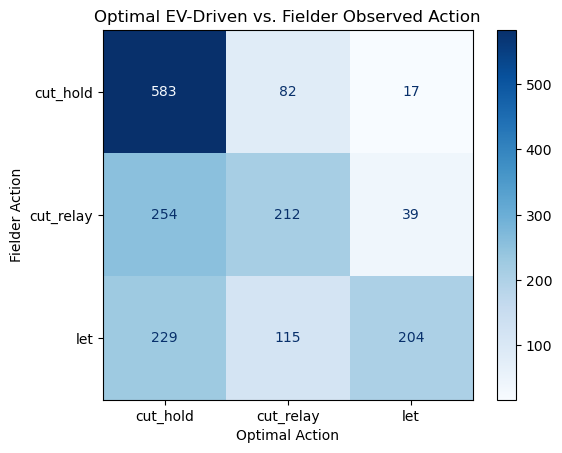

In [71]:
# ----- Using scikit-learn to create a confusion matrix ----- #


# Importing libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
che = confusion_matrix(design_matrix['optimal_action'], design_matrix['cutoff_decision'], labels = ['cut_hold', 'cut_relay', 'let'])

disp = ConfusionMatrixDisplay(confusion_matrix=che, display_labels=['cut_hold', 'cut_relay', 'let'])
disp.plot(cmap='Blues')

# Axis labeling and titling
plt.title("Optimal EV-Driven vs. Fielder Observed Action")
plt.xlabel("Optimal Action")
plt.ylabel("Fielder Action")
plt.show()

### Including Speed Into Larger Cutoff Model

In [72]:
# ---- Using prior "player_stats" dataframe to merge onto larger, design matrix dataframe ----- #
design_full = design_matrix.merge(player_stats, left_on = 'baserunner_player_id', right_on='player_id', how='left')

# ----- Cleaning null instances in speed metrics by filling null rows with the mean ----- #
design_full['pct90_speed_ft_per_s'] = design_full['pct90_speed_ft_per_s'].fillna(design_full['pct90_speed_ft_per_s'].mean())

# ----- Standardize a speed+ metric for easier readabiility and viewer understanding ----- #
design_full['speed_plus'] = (100 * design_full['pct90_speed_ft_per_s'] / design_full['pct90_speed_ft_per_s'].mean()).round(1)

# ---- Continue to organize dataset, creating a "basepath" column to identify which base runners started at and attempted to reach ----- #
design_full['basepath'] = design_full['from_base'] + '_to_' + design_full['to_base']

# ---- Add 'is' to basepath columns ----- #
base_dummies = pd.get_dummies(design_full[['basepath']], prefix = 'is')

design_full_encoded = pd.concat([design_full, base_dummies], axis=1)
design_full_encoded


,game_str,play_id,timestamp,baserunner_player_id,from_base,to_base,runner_x,runner_y,runner_dist_to_base,cutoff_x,cutoff_y,cutoff_dist_to_base,fielder_x,fielder_y,fielder_dist_to_base,as+,optimal_action,cutoff_decision,let,cut_hold,cut_relay,safe_probability,outs,player_id,num_appearances,peak_speed_ft_per_s,pct90_speed_ft_per_s,speed_plus,basepath,is_1B_to_3B,is_1B_to_Home,is_2B_to_Home,is_Home_to_2B,is_Home_to_3B
0,y1_d001_CGA_QEA,108,4098455,CGA-1824,Home,2B,35.7615,110.5899,39.346871,41.7405,194.3859,79.266190,94.4808,338.4810,231.626499,115.5,let,cut_relay,3.030436,3.253,3.095591,0.997912,1,CGA-1824,7.0,28.322210,27.656672,104.3,Home_to_2B,False,False,False,True,False
1,y1_d001_CGA_QEA,114,4231155,CGA-1353,Home,2B,61.1802,61.2882,89.783392,25.8921,137.6235,27.986775,139.5966,299.0814,221.583436,109.8,cut_hold,cut_hold,0.564000,0.564,0.519137,0.905948,1,NaN,NaN,NaN,26.515690,100.0,Home_to_2B,False,False,False,True,False
2,y1_d001_CGA_QEA,216,8333280,CGA-1929,Home,2B,56.9868,46.3326,98.766010,11.6007,132.4140,12.801861,188.1207,245.4093,222.283963,109.8,cut_relay,cut_hold,1.563679,1.564,1.481811,0.827697,1,NaN,NaN,NaN,26.515690,100.0,Home_to_2B,False,False,False,True,False
3,y1_d002_CGA_QEA,92,3087421,QEA-0252,Home,2B,57.1884,47.2554,98.131108,-55.6794,140.5182,57.296922,-200.5506,236.1000,228.305395,94.7,cut_relay,cut_relay,2.797617,2.809,2.526508,0.834470,0,QEA-0252,27.0,28.366512,24.333189,91.8,Home_to_2B,False,False,False,True,False
4,y1_d003_CGA_QEA,92,3994106,QEA-0249,Home,2B,59.4930,72.1209,80.939068,18.4110,161.4603,39.070157,69.6903,327.1002,211.888716,106.3,cut_hold,cut_hold,0.273000,0.273,0.259442,0.950335,2,QEA-0249,49.0,27.627580,26.671594,100.6,Home_to_2B,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1730,y2_d094_QZE_RZQ,344,11857564,RZQ-0310,2B,Home,-13.8180,9.9936,17.053128,2.4942,88.6911,88.726164,233.5866,234.6720,331.109721,100.8,cut_relay,cut_hold,2.512677,2.539,2.438214,1.000000,2,RZQ-0310,87.0,30.062055,28.691501,108.2,2B_to_Home,False,False,True,False,False
1731,y2_d095_QZE_RZQ,97,2945498,RZQ-0409,2B,Home,-60.0858,78.1305,98.563068,-5.2521,51.3606,51.628440,-100.2816,242.7507,262.648628,118.6,cut_relay,cut_relay,1.560106,1.873,1.512933,0.799040,1,RZQ-0409,46.0,29.710083,28.026794,105.7,2B_to_Home,False,False,True,False,False
1732,y2_d095_QZE_RZQ,97,2945498,RZQ-0409,2B,Home,-60.0858,78.1305,98.563068,-5.2521,51.3606,51.628440,-100.2816,242.7507,262.648628,118.6,cut_relay,cut_relay,1.560106,1.873,1.512933,0.799040,2,RZQ-0409,46.0,29.710083,28.026794,105.7,2B_to_Home,False,False,True,False,False
1733,y2_d095_QZE_RZQ,261,8351098,QZE-2357,2B,Home,-38.8740,30.2727,49.270927,90.5235,113.6388,145.286892,230.5521,250.0368,340.106854,120.5,cut_hold,cut_hold,2.252985,2.253,2.249641,0.999991,1,QZE-2357,12.0,27.535706,27.071918,102.1,2B_to_Home,False,False,True,False,False


,basepath,outs,let,cut_hold,cut_relay
0,1B_to_3B,0,2.156671,2.240630,2.161460
1,1B_to_3B,1,1.613693,1.687281,1.609803
2,1B_to_3B,2,1.103186,1.215497,1.162389
3,1B_to_Home,0,2.910570,3.085596,3.051295
4,1B_to_Home,1,2.558081,2.721170,2.669053
5,1B_to_Home,2,1.639909,1.893714,1.836777
6,2B_to_Home,0,2.224246,2.305330,2.230183
7,2B_to_Home,1,1.756970,1.815013,1.760708
8,2B_to_Home,2,1.365341,1.456367,1.414111
9,Home_to_2B,0,2.131126,2.207780,2.138459


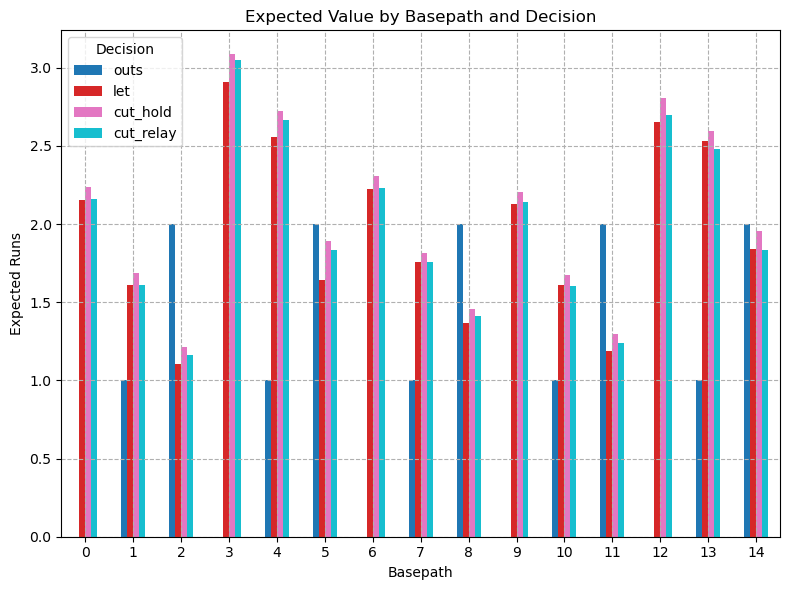

In [73]:
# ----- Expected Run Value Distribution by Optimal Action Stacked Bar Plot ------ #

ev_by_basepath = design_full_encoded[['let', 'cut_hold', 'cut_relay', 'basepath', 'outs']].groupby(['basepath', 'outs'])[['let', 'cut_hold', 'cut_relay']].mean().reset_index()
display(ev_by_basepath)
ev_by_basepath.plot(kind = 'bar', figsize = (8,6), colormap = 'tab10')
plt.title("Expected Value by Basepath and Decision")
plt.xlabel("Basepath")
plt.ylabel("Expected Runs")
plt.legend(title="Decision")
plt.grid(True, linestyle = '--',)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

      basepath  outs optimal_action
0     1B_to_3B     0       cut_hold
1     1B_to_3B     1       cut_hold
2     1B_to_3B     2       cut_hold
3   1B_to_Home     0       cut_hold
4   1B_to_Home     1       cut_hold
5   1B_to_Home     2       cut_hold
6   2B_to_Home     0       cut_hold
7   2B_to_Home     1       cut_hold
8   2B_to_Home     2       cut_hold
9   Home_to_2B     0       cut_hold
10  Home_to_2B     1       cut_hold
11  Home_to_2B     2       cut_hold
12  Home_to_3B     0       cut_hold
13  Home_to_3B     1       cut_hold
14  Home_to_3B     2       cut_hold


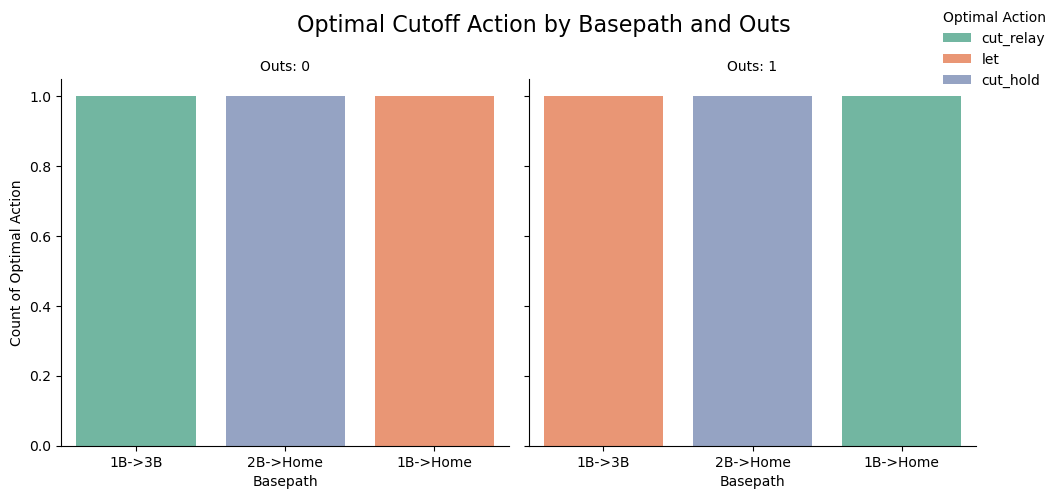

In [74]:
# Assumes your DataFrame looks like this:
# basepath | outs | let | cut_hold | cut_relay

# Step 1: Melt into long format
ev_by_basepath_melted = ev_by_basepath.melt(
    id_vars=['basepath', 'outs'],
    value_vars=['let', 'cut_hold', 'cut_relay'],
    var_name='action',
    value_name='ev'
)

# Step 2: Get the optimal action per basepath/outs group
optimal_actions = ev_by_basepath_melted.loc[
    ev_by_basepath_melted.groupby(['basepath', 'outs'])['ev'].idxmax()
].reset_index(drop=True)

# Optional: clean up the result
optimal_actions = optimal_actions[['basepath', 'outs', 'action']]
optimal_actions = optimal_actions.rename(columns={'action': 'optimal_action'})

# Display result
print(optimal_actions)


# Your dataframe (replace with your actual data)
optimal_actions = pd.DataFrame({
    'basepath': ['1B->3B', '1B->3B', '2B->Home', '2B->Home', '1B->Home', '1B->Home'],
    'outs': [0, 1, 0, 1, 0, 1],
    'optimal_action': ['cut_relay', 'let', 'cut_hold', 'cut_hold', 'let', 'cut_relay']
})

# Create the faceted bar plot
g = sns.catplot(
    data=optimal_actions,
    kind='count',
    x='basepath',
    hue='optimal_action',
    col='outs',
    palette='Set2',
    height=5,
    aspect=1
)

# Customize the plot
g.set_axis_labels("Basepath", "Count of Optimal Action")
g.set_titles("Outs: {col_name}")
g._legend.set_title("Optimal Action")
g._legend.set_bbox_to_anchor((0.95, 0.9))
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Optimal Cutoff Action by Basepath and Outs", fontsize=16)

plt.show()


# Step 5: Train the Main Model



### Using a Random Forest Classifier to predict optimal cutoff decisions, calculated by expected run value (EV), using physical features such as fielder_dist_to_base, arm strength, etc.

In [75]:
# ----- Import necessary libraries and packages ----- #
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ----- Outline features & target variable ----- #
features = ['fielder_dist_to_base', 'runner_dist_to_base', 'cutoff_dist_to_base', 
            'as+', 'pct90_speed_ft_per_s', 'outs'] + list(base_dummies.columns)
            
label = 'optimal_action' 

# ----- Split final dataset into features and target variables ----- #
X = design_full_encoded[features]
y = design_full_encoded[label]
indices = design_full_encoded.index

# ----- Use scikit-learn's train-test split to split the data into 75% training data and 25% testing data, randomizing it in the process ----- #
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, indices, test_size=0.25, stratify=y, random_state=42
)

# ----- Run the model ----- #
model = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)

In [76]:
# ----- Assign a variable to the predicted cutoff decisions made by the random forest classifier ------ #
y_pred = model.predict(X_test)

# ----- Print a classification report, detailing accuracy overall and between the encoded cutoff decisions ----- #
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    cut_hold       0.72      0.88      0.79       171
   cut_relay       0.74      0.59      0.65       126
         let       0.71      0.65      0.68       137

    accuracy                           0.72       434
   macro avg       0.72      0.70      0.71       434
weighted avg       0.72      0.72      0.72       434



### Exploring Feature Importance

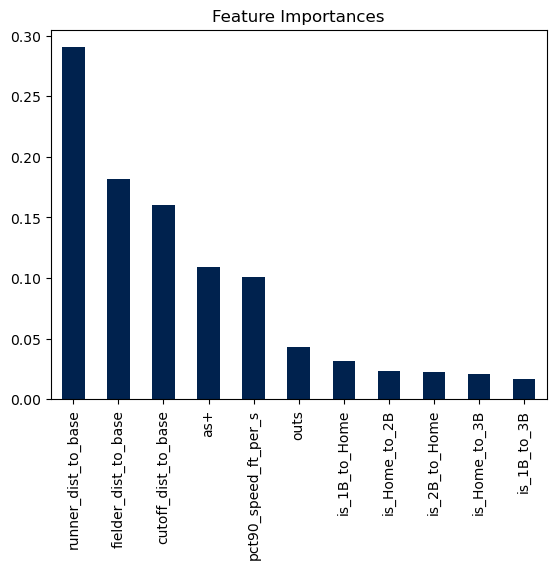

In [77]:
# ----- Use scikit-learn's feature_importance_ function to see which features swung the classifiers decision making most drastically ----- #

importances = model.feature_importances_
feat_importance = pd.Series(importances, index=features).sort_values(ascending=False)
feat_importance.plot(kind='bar', title='Feature Importances', colormap='cividis')
plt.show()

In [78]:
# ----- Add a column into the main dataframe, which shows the classifier model's prediction ----- #

results_df = design_full_encoded.loc[idx_test].copy()
results_df['model_prediction'] = y_pred
display(results_df)

,game_str,play_id,timestamp,baserunner_player_id,from_base,to_base,runner_x,runner_y,runner_dist_to_base,cutoff_x,cutoff_y,cutoff_dist_to_base,fielder_x,fielder_y,fielder_dist_to_base,as+,optimal_action,cutoff_decision,let,cut_hold,cut_relay,safe_probability,outs,player_id,num_appearances,peak_speed_ft_per_s,pct90_speed_ft_per_s,speed_plus,basepath,is_1B_to_3B,is_1B_to_Home,is_2B_to_Home,is_Home_to_2B,is_Home_to_3B,model_prediction
235,y1_d071_ACN_QEA,76,2166315,QEA-0071,Home,2B,61.2537,57.5949,92.569345,50.7417,69.8625,76.416059,5.0262,381.7059,254.755487,94.2,cut_relay,cut_hold,0.564000,0.564,0.509324,0.885376,1,QEA-0071,21.0,27.333517,25.801600,97.3,Home_to_2B,False,False,False,True,False,cut_relay
122,y1_d048_MHY_RZQ,109,3746237,MHY-1634,Home,2B,60.9834,64.5579,87.281103,20.0100,131.5017,20.510129,-176.0010,239.0067,208.618918,121.2,cut_hold,cut_hold,0.273000,0.273,0.251529,0.921353,2,NaN,NaN,NaN,26.515690,100.0,Home_to_2B,False,False,False,True,False,cut_relay
482,y2_d067_HKR_RZQ,82,2689815,HKR-1921,Home,2B,56.9709,83.9352,71.416108,-80.9712,110.6772,82.600055,-192.3600,237.4956,221.836983,121.2,cut_hold,cut_hold,2.252934,2.253,2.221354,0.975577,1,HKR-1921,8.0,26.148504,25.275682,95.3,Home_to_2B,False,False,False,True,False,cut_hold
1143,y2_d095_QZE_RZQ,97,2945498,RZQ-0040,1B,3B,10.9254,123.0792,95.357314,-5.2521,51.3606,59.665153,-100.2816,242.7507,182.820266,118.6,cut_relay,cut_relay,1.560106,1.873,1.512933,0.541899,1,RZQ-0040,80.0,27.584712,25.822769,97.4,1B_to_3B,True,False,False,False,False,cut_relay
811,y1_d071_ACN_QEA,165,5426715,ACN-1433,1B,3B,-9.6519,123.9423,80.938757,-1.8366,43.3497,65.048878,-202.2630,210.1392,201.688750,115.1,cut_relay,cut_hold,1.116647,1.253,1.021252,0.860864,1,NaN,NaN,NaN,26.515690,100.0,1B_to_3B,True,False,False,False,False,cut_relay
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,y2_d051_DYE_RZQ,300,9299480,RZQ-0346,Home,2B,57.9213,84.3435,71.933678,52.0215,67.0380,79.383108,179.7195,204.5376,195.732415,103.6,cut_hold,cut_hold,0.538388,0.539,0.524767,0.974701,2,RZQ-0346,58.0,30.354954,26.812335,101.1,Home_to_2B,False,False,False,True,False,cut_hold
682,y1_d038_HMN_RZQ,273,10047061,HMN-2390,1B,3B,-34.0881,108.4152,53.648237,-70.8681,84.7050,22.270601,-165.5793,180.9276,155.396274,121.2,cut_relay,cut_hold,2.251788,2.253,2.162132,0.965557,1,HMN-2390,8.0,25.336525,24.816931,93.6,1B_to_3B,True,False,False,False,False,cut_hold
375,y2_d019_GIS_RZQ,60,1810231,RZQ-0143,Home,2B,47.8620,95.5722,57.257992,-45.7167,194.4960,81.521327,-60.3111,318.7008,200.964239,120.6,cut_hold,cut_hold,0.537823,0.539,0.533376,0.991732,2,RZQ-0143,48.0,29.038316,27.774209,104.7,Home_to_2B,False,False,False,True,False,cut_hold
1295,y2_d078_MGJ_RZQ,16,482299,MGJ-2494,1B,Home,-58.0677,84.1920,102.274878,-11.2464,104.9217,105.522721,217.5468,258.8538,338.130005,120.5,let,cut_hold,2.683303,2.809,2.808529,0.919218,0,NaN,NaN,NaN,26.515690,100.0,1B_to_Home,False,True,False,False,False,let


### Exploring Classifier Model Decision Making vs Observed Decision Making

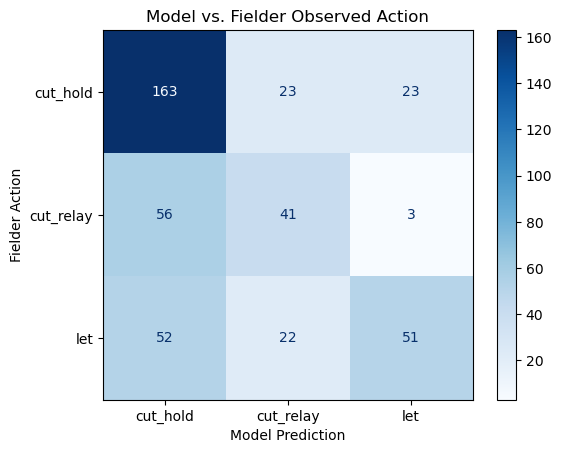

In [79]:
# ----- Using confusion matrix from scikit-learn previously, assign y-axis to observed cutoff decisions and x-axis to model predicted cutoff decisions ----- #
cm = confusion_matrix(results_df['model_prediction'], results_df['cutoff_decision'], labels=model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')

# Assign axis and titles
plt.title("Model vs. Fielder Observed Action")
plt.xlabel("Model Prediction")
plt.ylabel("Fielder Action")
plt.show()